In [1]:
##Celda 1
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import plotly.express as px
from IPython.display import display
from matplotlib.ticker import FuncFormatter

## Indices

In [2]:
##Celda 2

ruta = "PARAMETROS_PERFECT.xlsx"
hoja = "2025"
col_cod = "Codigo Compra"

df_items = pd.read_excel(ruta, sheet_name=hoja, usecols=[col_cod],   # <- lista
    dtype=str)

df_items[col_cod] = df_items[col_cod].str.strip()
I = (df_items[col_cod].dropna().loc[lambda s: s.ne("")].drop_duplicates(keep="first").tolist())

print(f"{len(I)} items cargados:", I[:10], "..." if len(I) > 10 else "")

T = list(range(1, 13)) ##Horizonte de tiempo
M = ['1', '2'] ##Maritimo=1, Aereo=2
A = list(range(1, 13)) ##Buckets de inventario 


1983 items cargados: ['SNPA157C', 'SNPCT9050U2', 'SNPHSBM1218B', 'SNPBOER704', 'SNPHS5A', 'SNPSDML19KT', 'SNPAWMBPH9', 'SNPDBTB121', 'SNPTA3', 'BPTAHRB200'] ...


## Parámetros

In [3]:
## Celda 3 - COSTOS COMPRA

col_cod  = "Codigo Compra"
col_cost = "CU"

df = pd.read_excel(ruta, sheet_name=hoja, usecols=[col_cod, col_cost], dtype={col_cod: str})
df[col_cod] = df[col_cod].str.strip()

C_i = (df.dropna(subset=[col_cod, col_cost]).drop_duplicates(subset=[col_cod]).set_index(col_cod)[col_cost].astype(float).reindex(I).fillna(0.0).to_dict())

print("Ejemplo C_i:", list(C_i.items())[:5])


Ejemplo C_i: [('SNPA157C', 183953.1729), ('SNPCT9050U2', 499413.1761), ('SNPHSBM1218B', 23858.7107), ('SNPBOER704', 144390.34790000002), ('SNPHS5A', 13348.962599999999)]


In [4]:
## Celda 4 - Costos transporte

M = ['1', '2']
pct_m = {'1': 0.05 , '2': 0.15}

##C_im[i][m] = % del modo m * costo unitario del ítem i
C_im = {i: {m: pct_m[m] * C_i[i] for m in M} for i in I} ## >>>> ESTE ES EL PROBLEMA


In [5]:
## Celda 5

ruta = "PARAMETROS_PERFECT.xlsx"

##Códigos productos desde COMPRA2.0
df_compra = pd.read_excel(ruta, sheet_name="2025",
                          usecols=["Codigo Compra"], dtype=str)
I = (df_compra["Codigo Compra"]
     .astype(str).str.strip().str.upper()
     .dropna().loc[lambda s: s.ne("")].drop_duplicates().tolist())

##Demanda desde VENTA2.0
df_venta = pd.read_excel(ruta, sheet_name="VENTA2.0",
                         usecols=["Mes", "Código", "Demanda"])

##Normal
df_venta["Código"] = (df_venta["Código"].astype(str)
                      .str.strip().str.upper())

##Mes -> número 1..12
mes_map = {
    "enero": 1, "febrero": 2, "marzo": 3, "abril": 4, "mayo": 5, "junio": 6,
    "julio": 7, "agosto": 8, "septiembre": 9, "setiembre": 9, "octubre": 10, "noviembre": 11, "diciembre": 12}

def mes_a_num(x):
    if pd.isna(x):
        return None
    s = str(x).strip().lower()
    palabra = s.split()[0]
    return mes_map.get(palabra, None)

df_venta["MesNum"] = df_venta["Mes"].map(mes_a_num)

##Limpiar
df_venta["Demanda"] = pd.to_numeric(df_venta["Demanda"], errors="coerce").fillna(0.0)

##Filad Validas
df_venta = df_venta.dropna(subset=["Código", "MesNum"])
df_venta = df_venta.loc[df_venta["Código"] != ""]

#Suma demanda por (Código, Mes)
T = list(range(1, 13))
pvt = (df_venta
       .pivot_table(index="Código", columns="MesNum",
                    values="Demanda", aggfunc="sum", fill_value=0.0)
       .reindex(columns=T, fill_value=0.0))

##Ocupamos solo códigos(i) que están en COMPRA2.0
pvt = pvt.loc[pvt.index.intersection(I)]

##D_it con los códigos de I (0 si no aparece en VENTA2.0)
D_it = {
    i: {t: float(pvt.loc[i, t]) if i in pvt.index else 0.0 for t in T}
    for i in I
}

##Chequeos rápido
print("Items en COMPRA2.0:", len(I))
print("Items con ventas en VENTA2.0:", pvt.shape[0])
print("Suma total de demanda:", pvt.values.sum())
ej_i = next((i for i in I if i in pvt.index), I[0] if I else None)
if ej_i:
    print("Ejemplo D_it:", (ej_i, D_it[ej_i]))


Items en COMPRA2.0: 1983
Items con ventas en VENTA2.0: 799
Suma total de demanda: 22374.0
Ejemplo D_it: ('SNPA157C', {1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 1.0})


#### INVENTARIO EN 25% BUCKET 12

In [6]:
## Celda 6

ruta = "PARAMETROS_PERFECT.xlsx"

## INVENTARIO
df_inv = pd.read_excel(ruta, sheet_name="INVENTARIO", usecols=["Codigo", "Inventario"])

# Normalizar código y cantidad
df_inv["Codigo"] = df_inv["Codigo"].astype(str).str.strip().str.upper()
df_inv["Inventario"] = (
    df_inv["Inventario"].astype(str)
    .str.replace(".", "", regex=False)
    .str.replace(",", ".", regex=False)
)
df_inv["Inventario"] = pd.to_numeric(df_inv["Inventario"], errors="coerce").fillna(0.0)

# Ocupar solo códigos de I
df_inv = df_inv[df_inv["Codigo"].isin(I)]

## SUMAR por código
inv_por_codigo = df_inv.groupby("Codigo", as_index=True)["Inventario"].sum()

# ===== Reparto inicial con aleatoriedad reproducible =====
SEED = 12345
rng = np.random.default_rng(SEED)

pct_fijo_12 = 0.25
buckets_rand = list(range(1, 12))  # 1..11

# Crear estructura I_i0 (A ya existe: A = 1..12)
I_i0 = {i: {a: 0.0 for a in A} for i in I}

for i in I:
    qty = float(inv_por_codigo.get(i, 0.0))
    qty_int = int(round(qty))
    if qty_int > 0:
        # 25% entero para el bucket 12
        asign_12 = int(round(pct_fijo_12 * qty_int))
        restante = qty_int - asign_12
        I_i0[i][12] += asign_12

        if restante > 0:
            # proporciones aleatorias para repartir el restante entre 1..11
            prop = rng.dirichlet(alpha=np.ones(len(buckets_rand)))
            # asignación "real"
            asign_real = prop * restante
            # parte entera
            asign_floor = np.floor(asign_real).astype(int)
            sobrantes = restante - int(asign_floor.sum())

            # ordenar por parte fraccional descendente y repartir +1 a los primeros 'sobrantes'
            frac = asign_real - asign_floor
            order = np.argsort(-frac)  # índices con fracción más grande primero
            asign_int = asign_floor.copy()
            if sobrantes > 0:
                asign_int[order[:sobrantes]] += 1

            # Volcar asignación entera a los buckets
            for b, units in zip(buckets_rand, asign_int):
                if units > 0:
                    I_i0[i][b] += int(units)

items_con_stock = sum(1 for i in I if sum(I_i0[i].values()) > 0)
print(f"Items con inventario inicial > 0: {items_con_stock}/{len(I)}")
for i in I:
    if sum(I_i0[i].values()) > 0:
        print("Ejemplo I_i0:", i, {a: int(v) for a, v in I_i0[i].items()})
        break


Items con inventario inicial > 0: 847/1983
Ejemplo I_i0: SNPA157C {1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}


In [7]:
## Celda 7

#Recepciones comprometidas en cero
Rc_it = {i: {t: 0.0 for t in T} for i in I}


In [ ]:
## Celda 8

#cortes y valores editables
L_M = 50000   
M_M = 500000
P_L = 5000
P_M = 10000
P_H = 20000

O_age = {}
for i in I:
    cu = float(C_i.get(i, 0.0))
    if cu < L_M:
        p = P_L
    elif cu <= M_M:
        p = P_M
    else:
        p = P_H
    O_age[i] = {a: p * a for a in A}


#### PARÁMETRO ORDEN MÍNIMA ####

In [9]:
## Celda 9

M_i = {}
for i in I:
    cu = float(C_i.get(i, 0.0))
    if cu < 1000:
        M_i[i] = 20
    elif 1000 <= cu <= 20000:       
        M_i[i] = 10
    elif 20001 <= cu <= 50000:
        M_i[i] = 5
    else:                        
        M_i[i] = 0

# chequeo rápido
print("Ejemplos M_i:", list(M_i.items())[:10])


Ejemplos M_i: [('SNPA157C', 0), ('SNPCT9050U2', 0), ('SNPHSBM1218B', 5), ('SNPBOER704', 0), ('SNPHS5A', 10), ('SNPSDML19KT', 0), ('SNPAWMBPH9', 5), ('SNPDBTB121', 0), ('SNPTA3', 10), ('BPTAHRB200', 0)]


In [10]:
##celda 10

##Lead time por modo
lt_por_modo = {'1': 2, '2': 0}

##L_im para todos los ítems
L_im = {i: {m: lt_por_modo[m] for m in M} for i in I}


In [11]:
## Celda 11 -- Multa Backorders

N = 3500000

In [12]:
## Celda 12 -- Numero grande

Ñ = 1000

In [13]:
## Celda 13 -- Backorders iniciales

B_I = {i: 0 for i in I}

,Bucket,Inventario_inicial
0,1,826.0
1,2,685.0
2,3,765.0
3,4,832.0
4,5,706.0
5,6,754.0
6,7,783.0
7,8,772.0
8,9,767.0
9,10,744.0


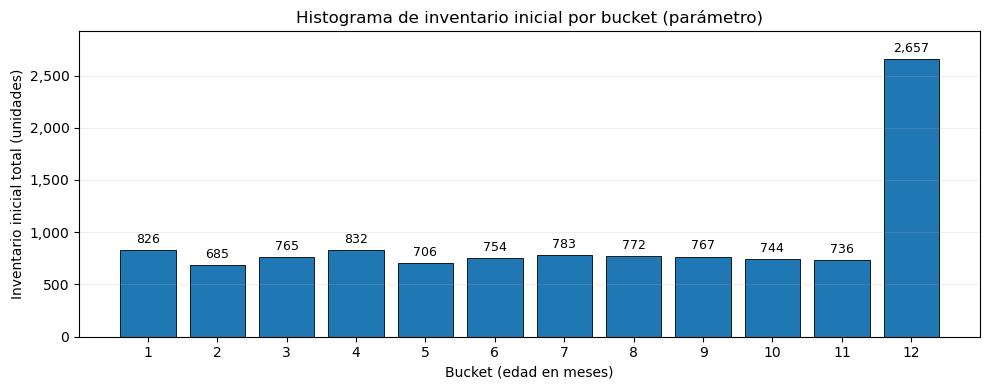

In [14]:
## Celda 14 -- Histograma inventario inicial por bucket

from matplotlib.ticker import FuncFormatter

# 1) Agregar inventario inicial por bucket (usa I_i0 que ya creaste)
bucket_sums = {a: 0.0 for a in A}
for i in I:
    for a, qty in I_i0[i].items():
        bucket_sums[a] += float(qty)

df_hist_ini = (pd.DataFrame({
    "Bucket": list(bucket_sums.keys()),
    "Inventario_inicial": [bucket_sums[a] for a in bucket_sums.keys()]}).sort_values("Bucket"))

display(df_hist_ini)

# 2) Gráfico (azul, con etiquetas y miles formateados)
fig, ax = plt.subplots(figsize=(10, 4))
bars = ax.bar(df_hist_ini["Bucket"], df_hist_ini["Inventario_inicial"],
              color="tab:blue", edgecolor="black", linewidth=0.6)

ax.set_title("Histograma de inventario inicial por bucket (parámetro)")
ax.set_xlabel("Bucket (edad en meses)")
ax.set_ylabel("Inventario inicial total (unidades)")
ax.set_xticks(df_hist_ini["Bucket"])
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))
ax.grid(axis="y", alpha=0.2)

ymax = df_hist_ini["Inventario_inicial"].max()
ax.set_ylim(0, ymax * 1.10 if ymax > 0 else 1)

for bar in bars:
    h = bar.get_height()
    if h > 0:
        ax.annotate(f"{h:,.0f}",
                    xy=(bar.get_x() + bar.get_width()/2, h),xytext=(0, 3), textcoords="offset points",ha="center", va="bottom", fontsize=9)

fig.tight_layout()
plt.show()


In [ ]:
##Celda 15

##Inicializadores(fuera del bucle)
K = 4
F = 1
plan_ejecutado = []
plan_sugerido  = []
costo_total = 0
pedidos_en_transito = {i: {t: 0.0 for t in T} for i in I}

##Acumuladores globales(rolling horizon)
costo_compra = 0.0        # f1
back_total   = 0.0        # f2
obso_total   = 0.0        
costo_aug    = 0.0        
costo_equiv_antiguo = 0.0

##Backorder real al final del horizonte(t = T[-1]) para reportes
backorder_final_horiz = {i: 0.0 for i in I}

periodos_registrados = set()
served_hist  = {}
demand_hist  = {}

##Puntos Pareto recolectados(todas las ventanas)
pareto_points = []   


### NUEVA CELDA  PARA PUNTOS NO DOMINADOS ###

In [ ]:
##CELDA 16, AUGMECON PRIMERA VENTANA (PRIMER MES)

def _safe(expr):
    try:
        return float(expr.getValue())
    except Exception:
        try:
            return float(expr)
        except Exception:
            return float('nan')

#Primera ventana fija: t = 1..K 
win = T[:K]
t_ini = win[0]

m1 = gp.Model(f"AUGMECON_win_{t_ini}")

#Variables (RECORDAR ESTO ES LA PRIMERA VENTANA)
X_itm = m1.addVars(I, win, M, lb=0.0, vtype=GRB.INTEGER, name="X_itm")
B_it  = m1.addVars(I, win, lb=0.0, vtype=GRB.INTEGER, name="B_it")
R_it  = m1.addVars(I, win, lb=0.0, vtype=GRB.INTEGER, name="R_it")
I_ita = m1.addVars(I, win, A, lb=0.0, vtype=GRB.INTEGER, name="I_ita")
S_ita = m1.addVars(I, win, A, lb=0.0, vtype=GRB.INTEGER, name="S_ita")
Y_it  = m1.addVars(I, win, vtype=GRB.BINARY, name="Y_it")

# Restricciones 
# (1) Recepciones con lead time
for i in I:
    for t in win:
        if t == t_ini:
            m1.addConstr(R_it[i, t] == Rc_it[i][t] + pedidos_en_transito[i][t], name=f"recep_ini_{i}_{t}")
        else:
            m1.addConstr(
                R_it[i, t] == Rc_it[i][t] + gp.quicksum(X_itm[i, t - L_im[i][m_], m_] for m_ in M if (t - L_im[i][m_]) in win), name=f"recep_{i}_{t}")

# (2) Mínimo de orden
for i in I:
    for t in win:
        m1.addConstr(gp.quicksum(X_itm[i, t, m_] for m_ in M) >= M_i[i] * Y_it[i, t], name=f"min_order_qty_{i}_{t}")

# (3) Máximo de orden con Big-M
for i in I:
    for t in win:
        m1.addConstr(gp.quicksum(X_itm[i, t, m_] for m_ in M) <= Ñ * Y_it[i, t], name=f"max_order_bigM_{i}_{t}")

# (4) Inventario bucket 1
for i in I:
    for t in win:
        m1.addConstr(I_ita[i, t, 1] == R_it[i, t] - S_ita[i, t, 1], name=f"inv_edad1_{i}_{t}")

# (5) Buckets 2..11
for i in I:
    for t in win:
        for a in range(2, 12):
            if t == t_ini:
                m1.addConstr(I_ita[i, t, a] == I_i0[i][a-1] - S_ita[i, t, a], name=f"envejec_ini_{i}_t{t}_a{a}")
            else:
                m1.addConstr(I_ita[i, t, a] == I_ita[i, t-1, a-1] - S_ita[i, t, a], name=f"envejec_{i}_t{t}_a{a}")

# (6) Bucket final (edad 12)
for i in I:
    for t in win:
        if t == t_ini:
            m1.addConstr(I_ita[i, t, 12] == I_i0[i][11] + I_i0[i][12] - S_ita[i, t, 12], name=f"envejec_final_ini_{i}_{t}")
        else:
            m1.addConstr(I_ita[i, t, 12] == I_ita[i, t-1, 11] + I_ita[i, t-1, 12] - S_ita[i, t, 12], name=f"envejec_final_{i}_{t}")

# (7) Demanda con backorder
for i in I:
    for t in win:
        if t == t_ini:
            m1.addConstr(gp.quicksum(S_ita[i, t, a] for a in A) == D_it[i][t] + B_I[i] - B_it[i, t], name=f"satis_dem_ini_{i}_{t}")
        else:
            m1.addConstr(gp.quicksum(S_ita[i, t, a] for a in A) == D_it[i][t] + B_it[i, t-1] - B_it[i, t], name=f"satis_dem_{i}_{t}")

# -------- Objetivos (2 objetivos) --------
# f1: compra+flete + obsolescencia (O_age*I)
f1 = gp.quicksum((C_im[i][m_] + C_i[i]) * X_itm[i, t, m_] for i in I for t in win for m_ in M) \
   + gp.quicksum(O_age[i][a] * I_ita[i, t, a] for i in I for t in win for a in A)

# f2: backorders (unidades)
f2 = gp.quicksum(B_it[i, t] for i in I for t in win)

m1._f1, m1._f2 = f1, f2

# -------- Payoff --------
m1.setObjective(m1._f1, GRB.MINIMIZE); m1.optimize()
assert m1.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f1"
f1_min = _safe(m1._f1)

m1.setObjective(m1._f2, GRB.MINIMIZE); m1.optimize()
assert m1.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f2"
f2_min = _safe(m1._f2)

#z2^lex (min f2 s.a. f1 <= f1_min
c_cap = m1.addConstr(m1._f1 <= f1_min, name=f"cap_f1_for_lex_{t_ini}")
m1.update()

m1.setObjective(m1._f2, GRB.MINIMIZE); m1.optimize()
assert m1.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar z2_lex"
z2_lex = _safe(m1._f2)

m1.remove(c_cap); m1.update()

# -------- Normalizador y ρ --------
r2  = max(1.0, z2_lex - f2_min)
rho = 1e-5 * max(1.0, abs(f1_min))

#Barrido AUGMECON
grid_frac = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2_vals = f2_min + grid_frac * (z2_lex - f2_min)

pareto_first = []   # lista de dict con resultados del primer período

#Param guardado
old_gap = m1.Params.MIPGap
old_tl  = m1.Params.TimeLimit

try:
    m1.Params.MIPGap    = 0.01
    m1.Params.TimeLimit = 30

    for eps2 in eps2_vals:
        #Holgura y restricción de igualdad f2 + s2 = eps2
        s2 = m1.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"s2_eps_{int(round(eps2))}")
        c2 = m1.addConstr(m1._f2 + s2 == float(eps2), name=f"eps2_eq_{int(round(eps2))}")
        m1.update()

        #Objetivo AUGMECON
        m1.setObjective(m1._f1 - rho * (s2 / r2), GRB.MINIMIZE)

        #Warm-start 
        for v in m1.getVars():
            if v.VType != GRB.BINARY:
                try: v.Start = v.X
                except: pass

        m1.optimize()
        if m1.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            #Snapshot SOLO del primer período ejecutable (t = t_ini)
            X1 = {(i, m_): float(X_itm[i, t_ini, m_].X) for i in I for m_ in M}
            B1 = {i: float(B_it[i, t_ini].X) for i in I}
            I1 = {(i, a): float(I_ita[i, t_ini, a].X) for i in I for a in A}
            S1 = {(i, a): float(S_ita[i, t_ini, a].X) for i in I for a in A}

            pareto_first.append({
                "t_inicial": t_ini,
                "eps2": float(eps2),
                "f1": _safe(m1._f1),
                "f2": _safe(m1._f2),
                "rho": float(rho),
                "r2": float(r2),
                "X_tini": X1, "B_tini": B1, "I_tini": I1, "S_tini": S1
            })

        
        try:
            m1.remove(c2); m1.remove(s2); m1.update()
        except:
            pass
finally:
    m1.Params.MIPGap    = old_gap
    m1.Params.TimeLimit = old_tl

# DataFrame para revisar
df_pareto_first = pd.DataFrame(pareto_first)
display(df_pareto_first[["t_inicial","eps2","f1","f2"]].sort_values(["f2","f1"]))
print("Listo: frente de Pareto (primera ventana) generado.")


Set parameter Username
Set parameter LicenseID to value 2722105


Academic license - for non-commercial use only - expires 2026-10-14
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0xd8df07a1
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 107651 rows and 200590 columns
Presolve time: 0.25s
Presolved: 19261 rows, 29438 columns, 59645 nonzeros
Variable types: 0 continuous, 29438 integer (9061 binary)
Found heuristic solution: objective 1.928575e+09
Performing another presolve...
Presolve removed 23602 rows and 29375 columns
Presolve time: 0.82s
Found heuristic solution: objective 1.56728

,t_inicial,eps2,f1,f2
0,1,3024.0,1.952307e+09,3024.0
1,1,5242.8,1.770970e+09,5242.0
2,1,7461.6,1.729072e+09,7350.0
3,1,9680.4,1.687882e+09,9680.0
4,1,11899.2,1.661491e+09,11899.0
5,1,14118.0,1.638489e+09,14118.0
6,1,16336.8,1.619649e+09,16307.0
7,1,18555.6,1.601899e+09,18555.0
8,1,20774.4,1.599856e+09,20774.0
9,1,22993.2,1.589951e+09,22993.0


Listo: frente de Pareto (primera ventana) generado.


In [17]:
## CELDA 18 – TABLA PAYOFF + LEXICOGRÁFICA (PRIMERA VENTANA)

assert "m1" in globals(), "Primero ejecuta la CELDA 16 (AUGMECON primera ventana)."
assert hasattr(m1, "_f1") and hasattr(m1, "_f2"), "m1 debe tener _f1 y _f2 definidos."

def _safe_val(expr):
    try:
        return float(expr.getValue())
    except Exception:
        try:
            return float(expr)
        except Exception:
            return np.nan

# ---------- 1) Payoff: z1* = min f1, z2* = min f2 ----------

# z1*  (min f1)
m1.setObjective(m1._f1, GRB.MINIMIZE)
m1.optimize()
if m1.Status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
    raise RuntimeError("No se pudo optimizar f1 para payoff.")
z1_star = _safe_val(m1._f1)      # f1*
f2_at_z1 = _safe_val(m1._f2)     # f2 en ese punto (no va a la tabla, pero sirve de chequeo)

# z2*  (min f2)
m1.setObjective(m1._f2, GRB.MINIMIZE)
m1.optimize()
if m1.Status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
    raise RuntimeError("No se pudo optimizar f2 para payoff.")
z2_star = _safe_val(m1._f2)      # f2*
f1_at_z2 = _safe_val(m1._f1)     # f1 en ese punto (tampoco va a la tabla)

# ---------- 2) lex(f1,f2): primero f1, luego f2 ----------
# Mantener f1 en su mejor valor (<= z1*) y minimizar f2

c_lex12 = m1.addConstr(m1._f1 <= z1_star, name="cap_f1_lex_f1f2")
m1.update()

m1.setObjective(m1._f2, GRB.MINIMIZE)
m1.optimize()
if m1.Status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
    raise RuntimeError("No se pudo optimizar lex(f1,f2).")

z2_lex = _safe_val(m1._f2)       # z2^{lex}
# (f1 en este punto debería ser muy cercano a z1_star)
m1.remove(c_lex12)
m1.update()

# ---------- 3) lex(f2,f1): primero f2, luego f1 ----------
# Mantener f2 en su mejor valor (<= z2*) y minimizar f1

c_lex21 = m1.addConstr(m1._f2 <= z2_star, name="cap_f2_lex_f2f1")
m1.update()

m1.setObjective(m1._f1, GRB.MINIMIZE)
m1.optimize()
if m1.Status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
    raise RuntimeError("No se pudo optimizar lex(f2,f1).")

z1_lex2 = _safe_val(m1._f1)      # z1^{lex(2)}
m1.remove(c_lex21)
m1.update()

# ---------- 4) Armar tabla con el mismo formato teórico ----------

df_payoff_lex = pd.DataFrame([
    {
        "Caso": "lex(f1,f2)",
        "f1":   z1_star,   # z1*
        "f2":   z2_lex     # z2^{lex}
    },
    {
        "Caso": "lex(f2,f1)",
        "f1":   z1_lex2,   # z1^{lex(2)}
        "f2":   z2_star    # z2*
    }
])

print("\n=== TABLA PAYOFF / LEXICOGRÁFICA – PRIMERA VENTANA ===")
display(df_payoff_lex.style.format({"f1": "{:,.0f}", "f2": "{:,.0f}"}))


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0xd8df07a1
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 107651 rows and 200590 columns
Presolve time: 0.22s
Presolved: 19261 rows, 29438 columns, 59645 nonzeros
Variable types: 0 continuous, 29438 integer (9061 binary)
Found heuristic solution: objective 1.928575e+09
Performing another presolve...
Presolve removed 23602 rows and 29375 columns
Presolve time: 0.69s
Found heuristic solution: objective 1.567280e+09

Root relaxation: objective 1.566165e+09, 15 iterations, 0.00 

,Caso,f1,f2
0,"lex(f1,f2)","1,566,165,000","25,212"
1,"lex(f2,f1)","1,952,031,858","3,024"


In [18]:
## CELDA 19 -> RESULTADOS AUGMECON PRIMERA VENTANA Y ELECCIÓN

assert 'df_pareto_first' in globals() and not df_pareto_first.empty, "Ejecuta la Celda 16 primero."

# Gráfico 2D (trade-off): x=f2 (backorders), y=f1 (costo+obsolescencia)
fig = px.scatter(df_pareto_first, x="f2", y="f1", hover_data=["eps2"],title="Trade-off f1 (costo+obs) vs f2 (backorders) — Primera ventana")
fig.show()

# ======= ELECCIÓN =======
# Opción A: escoger por índice del DataFrame ordenado (menor f2 luego f1)
df_sorted = df_pareto_first.sort_values(["f2","f1"]).reset_index(drop=True)
display(df_sorted[["eps2","f2","f1"]])

# Cambia este índice si quieres escoger otro punto:
CHOICE_IDX = 0    # 0: más “servicio” (menor f2) dentro del frente muestreado
# Opción B: o define directamente un target de backorders para t_inicial (eps2):
EPS2_TARGET = None  # por ejemplo: EPS2_TARGET = 0.0  (si quieres intentar sin BO en t=1)

if EPS2_TARGET is not None:
    # escoger la fila más cercana al target
    k = int((df_pareto_first["f2"] - EPS2_TARGET).abs().idxmin())
    choice = df_pareto_first.iloc[k]
else:
    choice = df_sorted.iloc[CHOICE_IDX]

print("\n=== Solución elegida para ejecutar en t = 1 ===")
print(choice[["eps2","f2","f1"]])

# Publicar snapshot elegido como estado para arrancar HR
X_tini_sel = choice["X_tini"]
B_tini_sel = choice["B_tini"]
I_tini_sel = choice["I_tini"]
S_tini_sel = choice["S_tini"]

# Aplicar ejecución en t = 1:
t_exec = T[0]  # 1

# 1) Registrar órdenes ejecutadas en t=1
if 'plan_ejecutado' not in globals():
    plan_ejecutado = []
for (i, m_), q in X_tini_sel.items():
    if q > 1e-6:
        plan_ejecutado.append([t_exec, i, m_, q])

# 2) Actualizar backorder inicial para el próximo período (t=2)
for i in I:
    B_I[i] = float(B_tini_sel.get(i, 0.0))

# 3) Actualizar inventario por edades para el próximo período (t=2)
for i in I:
    for a in A:
        I_i0[i][a] = float(I_tini_sel.get((i, a), 0.0))

# 4) Actualizar pedidos en tránsito que lleguen fuera de la primera ventana
for i in I:
    for m_ in M:
        q = float(X_tini_sel.get((i, m_), 0.0))
        if q > 1e-6:
            llegada = t_exec + L_im[i][m_]
            if llegada <= T[-1] and llegada not in [t_exec]:
                pedidos_en_transito[i][llegada] += q

# 5) NUEVO: acumular costos globales del horizonte
costo_compra        += float(choice["f1"])
back_total          += float(choice["f2"])
costo_equiv_antiguo += float(choice["f1"]) + N * float(choice["f2"])

# 6) NUEVO: registrar Servido/Demandado en t=1 para el Fill Rate global
for i in I:
    dem_t = float(D_it.get(i, {}).get(t_exec, 0.0))
    srv_t = sum(S_tini_sel.get((i, a), 0.0) for a in A)
    srv_t = min(dem_t, srv_t)  # seguridad: nunca más que la demanda

    demand_hist.setdefault(i, {})[t_exec] = dem_t
    served_hist.setdefault(i, {})[t_exec] = srv_t

print("\nEstado para HR preparado (desde t=2).")

,eps2,f2,f1
0,3024.0,3024.0,1.952307e+09
1,5242.8,5242.0,1.770970e+09
2,7461.6,7350.0,1.729072e+09
3,9680.4,9680.0,1.687882e+09
4,11899.2,11899.0,1.661491e+09
5,14118.0,14118.0,1.638489e+09
6,16336.8,16307.0,1.619649e+09
7,18555.6,18555.0,1.601899e+09
8,20774.4,20774.0,1.599856e+09
9,22993.2,22993.0,1.589951e+09



=== Solución elegida para ejecutar en t = 1 ===
eps2              3024.0
f2                3024.0
f1      1952306857.53406
Name: 0, dtype: object

Estado para HR preparado (desde t=2).


In [19]:
## CELDA 20 – AUGMECON SEGUNDA VENTANA (t = 2..5)

# ----- Definir ventana 2: t = 2,3,4,5 -----
win2   = T[1:1+K]   # con K=4, esto es [2,3,4,5]
t_ini2 = win2[0]    # = 2

m2 = gp.Model(f"AUGMECON_win_{t_ini2}")

# ===== VARIABLES PARA VENTANA 2 =====
X_itm_2 = m2.addVars(I, win2, M, lb=0.0, vtype=GRB.INTEGER, name="X_itm_2")
B_it_2  = m2.addVars(I, win2, lb=0.0, vtype=GRB.INTEGER, name="B_it_2")
R_it_2  = m2.addVars(I, win2, lb=0.0, vtype=GRB.INTEGER, name="R_it_2")
I_ita_2 = m2.addVars(I, win2, A, lb=0.0, vtype=GRB.INTEGER, name="I_ita_2")
S_ita_2 = m2.addVars(I, win2, A, lb=0.0, vtype=GRB.INTEGER, name="S_ita_2")
Y_it_2  = m2.addVars(I, win2, vtype=GRB.BINARY, name="Y_it_2")

# ===== RESTRICCIONES (IGUALES A CELDA 16, PERO EN win2 Y CON m2) =====

# (1) Recepciones con lead time
for i in I:
    for t in win2:
        if t == t_ini2:
            m2.addConstr(
                R_it_2[i, t] == Rc_it[i][t] + pedidos_en_transito[i][t],
                name=f"recep2_ini_{i}_{t}"
            )
        else:
            m2.addConstr(
                R_it_2[i, t] == Rc_it[i][t] + gp.quicksum(
                    X_itm_2[i, t - L_im[i][m_], m_]
                    for m_ in M
                    if (t - L_im[i][m_]) in win2
                ),
                name=f"recep2_{i}_{t}"
            )

# (2) Mínimo de orden
for i in I:
    for t in win2:
        m2.addConstr(
            gp.quicksum(X_itm_2[i, t, m_] for m_ in M) >= M_i[i] * Y_it_2[i, t],
            name=f"min_order_qty2_{i}_{t}"
        )

# (3) Máximo de orden con Big-M
for i in I:
    for t in win2:
        m2.addConstr(
            gp.quicksum(X_itm_2[i, t, m_] for m_ in M) <= Ñ * Y_it_2[i, t],
            name=f"max_order_bigM2_{i}_{t}"
        )

# (4) Inventario bucket 1
for i in I:
    for t in win2:
        m2.addConstr(
            I_ita_2[i, t, 1] == R_it_2[i, t] - S_ita_2[i, t, 1],
            name=f"inv_edad1_2_{i}_{t}"
        )

# (5) Buckets 2..11
for i in I:
    for t in win2:
        for a in range(2, 12):
            if t == t_ini2:
                # ahora partimos desde I_i0 ACTUALIZADO tras ventana 1
                m2.addConstr(
                    I_ita_2[i, t, a] == I_i0[i][a-1] - S_ita_2[i, t, a],
                    name=f"envejec2_ini_{i}_t{t}_a{a}"
                )
            else:
                m2.addConstr(
                    I_ita_2[i, t, a] == I_ita_2[i, t-1, a-1] - S_ita_2[i, t, a],
                    name=f"envejec2_{i}_t{t}_a{a}"
                )

# (6) Bucket final (edad 12)
for i in I:
    for t in win2:
        if t == t_ini2:
            m2.addConstr(
                I_ita_2[i, t, 12] == I_i0[i][11] + I_i0[i][12] - S_ita_2[i, t, 12],
                name=f"envejec2_final_ini_{i}_{t}"
            )
        else:
            m2.addConstr(
                I_ita_2[i, t, 12] == I_ita_2[i, t-1, 11] + I_ita_2[i, t-1, 12] - S_ita_2[i, t, 12],
                name=f"envejec2_final_{i}_{t}"
            )

# (7) Demanda con backorder
for i in I:
    for t in win2:
        if t == t_ini2:
            # Ojo: B_I ya viene actualizado por la decisión de la ventana 1
            m2.addConstr(
                gp.quicksum(S_ita_2[i, t, a] for a in A)
                == D_it[i][t] + B_I[i] - B_it_2[i, t],
                name=f"satis_dem2_ini_{i}_{t}"
            )
        else:
            m2.addConstr(
                gp.quicksum(S_ita_2[i, t, a] for a in A)
                == D_it[i][t] + B_it_2[i, t-1] - B_it_2[i, t],
                name=f"satis_dem2_{i}_{t}"
            )

# ===== OBJETIVOS (f1 y f2) PARA VENTANA 2 =====
# f1: compra + transporte + obsolescencia
f1_2 = gp.quicksum((C_im[i][m_] + C_i[i]) * X_itm_2[i, t, m_]
                   for i in I for t in win2 for m_ in M) \
     + gp.quicksum(O_age[i][a] * I_ita_2[i, t, a]
                   for i in I for t in win2 for a in A)

# f2: backorders
f2_2 = gp.quicksum(B_it_2[i, t] for i in I for t in win2)

m2._f1, m2._f2 = f1_2, f2_2

# ===== PAYOFF =====
# min f1
m2.setObjective(m2._f1, GRB.MINIMIZE)
m2.optimize()
assert m2.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f1 en ventana 2"
f1_min_2 = _safe(m2._f1)

# min f2
m2.setObjective(m2._f2, GRB.MINIMIZE)
m2.optimize()
assert m2.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f2 en ventana 2"
f2_min_2 = _safe(m2._f2)

# ===== LÉXICO f1→f2 (para z2^lex) =====
c_cap2 = m2.addConstr(m2._f1 <= f1_min_2, name=f"cap_f1_for_lex_{t_ini2}")
m2.update()

m2.setObjective(m2._f2, GRB.MINIMIZE)
m2.optimize()
assert m2.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar z2_lex en ventana 2"
z2_lex_2 = _safe(m2._f2)

m2.remove(c_cap2)
m2.update()

# ===== Normalizador y rho (ventana 2) =====
r2_2  = max(1.0, z2_lex_2 - f2_min_2)
rho_2 = 1e-5 * max(1.0, abs(f1_min_2))

# ===== BARRIDO AUGMECON SOBRE f2 (ventana 2) =====
grid_frac_2 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2_vals_2 = f2_min_2 + grid_frac_2 * (z2_lex_2 - f2_min_2)

pareto_second = []   # resultados y snapshots para t=2

old_gap_2 = m2.Params.MIPGap
old_tl_2  = m2.Params.TimeLimit

try:
    m2.Params.MIPGap    = 0.01
    m2.Params.TimeLimit = 30

    for eps2 in eps2_vals_2:
        # slack y igualdad f2 + s2 = eps2
        s2_2 = m2.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"s2_2_eps_{int(round(eps2))}")
        c2_2 = m2.addConstr(m2._f2 + s2_2 == float(eps2), name=f"eps2_2_eq_{int(round(eps2))}")
        m2.update()

        # objetivo aumentado
        m2.setObjective(m2._f1 - rho_2 * (s2_2 / r2_2), GRB.MINIMIZE)

        # warm-start suave
        for v in m2.getVars():
            if v.VType != GRB.BINARY:
                try:
                    v.Start = v.X
                except:
                    pass

        m2.optimize()
        if m2.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            # snapshot SOLO del primer período de esta ventana: t = t_ini2 (o sea t=2)
            X2 = {(i, m_): float(X_itm_2[i, t_ini2, m_].X) for i in I for m_ in M}
            B2 = {i: float(B_it_2[i, t_ini2].X) for i in I}
            I2 = {(i, a): float(I_ita_2[i, t_ini2, a].X) for i in I for a in A}
            S2 = {(i, a): float(S_ita_2[i, t_ini2, a].X) for i in I for a in A}

            pareto_second.append({
                "t_inicial": t_ini2,
                "eps2": float(eps2),
                "f1": _safe(m2._f1),
                "f2": _safe(m2._f2),
                "rho": float(rho_2),
                "r2": float(r2_2),
                "X_tini": X2, "B_tini": B2, "I_tini": I2, "S_tini": S2
            })

        # limpiar restricción y slack antes del siguiente punto
        try:
            m2.remove(c2_2); m2.remove(s2_2); m2.update()
        except:
            pass

finally:
    m2.Params.MIPGap    = old_gap_2
    m2.Params.TimeLimit = old_tl_2

# DataFrame para revisar el frente aproximado de la segunda ventana
df_pareto_second = pd.DataFrame(pareto_second)
display(df_pareto_second[["t_inicial","eps2","f1","f2"]].sort_values(["f2","f1"]))

print("Listo: frente de Pareto (segunda ventana, t=2) generado.")


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0x7aab7020
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 107787 rows and 201181 columns
Presolve time: 0.16s
Presolved: 19125 rows, 28847 columns, 58566 nonzeros
Variable types: 0 continuous, 28847 integer (8540 binary)
Found heuristic solution: objective 1.759977e+09
Performing another presolve...
Presolve removed 23460 rows and 28789 columns
Presolve time: 0.67s
Found heuristic solution: objective 1.494420e+09

Root relaxation: objective 1.493610e+09, 8 iterations, 0.00 s

,t_inicial,eps2,f1,f2
0,2,3252.0,2.001220e+09,3252.0
1,2,6221.4,1.726567e+09,6221.0
2,2,9190.8,1.664490e+09,9190.0
3,2,12160.2,1.630672e+09,11934.0
4,2,15129.6,1.596405e+09,15129.0
5,2,18099.0,1.572229e+09,18099.0
6,2,21068.4,1.564071e+09,21004.0
7,2,24037.8,1.546949e+09,24032.0
8,2,27007.2,1.519386e+09,26965.0
9,2,29976.6,1.504240e+09,29876.0


Listo: frente de Pareto (segunda ventana, t=2) generado.


In [20]:
## CELDA 21 – RESULTADOS AUGMECON VENTANA 2 Y ELECCIÓN


# 1) Gráfico trade-off f1 vs f2 para la ventana 2
fig = px.scatter(
    df_pareto_second,
    x="f2",  # backorders
    y="f1",  # costo + obsolescencia
    hover_data=["eps2"],
    title="Trade-off f1 (costo+obs) vs f2 (backorders) — Segunda ventana (t=2)"
)
fig.show()

# 2) Tabla ordenada por backorders y luego costo
df_sorted2 = df_pareto_second.sort_values(["f2", "f1"]).reset_index(drop=True)
display(df_sorted2[["eps2", "f2", "f1"]])

# 3) ELECCIÓN DEL PUNTO
#    Opción A: escoger por índice de la tabla ordenada
CHOICE_IDX_2   = 0      # 0 = el que tiene menor f2 (y luego menor f1)
#    Opción B: fijar un target de backorders (f2) para t=2
EPS2_TARGET_2  = None   # por ejemplo: EPS2_TARGET_2 = 10000.0

if EPS2_TARGET_2 is not None:
    # fila cuya f2 está más cerca del target
    k2 = int((df_pareto_second["f2"] - EPS2_TARGET_2).abs().idxmin())
    choice2 = df_pareto_second.loc[k2]
else:
    choice2 = df_sorted2.iloc[CHOICE_IDX_2]

print("\n=== Solución elegida para ejecutar en t = 2 ===")
print(choice2[["eps2", "f2", "f1"]])

# 4) Extraer SNAPSHOT de la solución elegida (primer período de la ventana 2, t = 2)
X_tini_sel_2 = choice2["X_tini"]   # órdenes por (i, m) en t=2
B_tini_sel_2 = choice2["B_tini"]   # backorders por ítem en t=2
I_tini_sel_2 = choice2["I_tini"]   # inventario por edades en t=2
S_tini_sel_2 = choice2["S_tini"]   # servido por edades en t=2

t_exec = 2   # este es el período ejecutado de esta ventana

# 5) Registrar ÓRDENES EJECUTADAS en t=2
if 'plan_ejecutado' not in globals():
    plan_ejecutado = []

for (i, m_), q in X_tini_sel_2.items():
    if q > 1e-6:
        plan_ejecutado.append([t_exec, i, m_, q])

# 6) Actualizar BACKORDER INICIAL para el siguiente período (t=3)
for i in I:
    B_I[i] = float(B_tini_sel_2.get(i, 0.0))

# 7) Actualizar INVENTARIO por edades para el siguiente período (t=3)
for i in I:
    for a in A:
        I_i0[i][a] = float(I_tini_sel_2.get((i, a), 0.0))

# 8) Actualizar PEDIDOS EN TRÁNSITO generados en t=2
for i in I:
    for m_ in M:
        q = float(X_tini_sel_2.get((i, m_), 0.0))
        if q > 1e-6:
            llegada = t_exec + L_im[i][m_]
            # solo sumamos si llega en el horizonte y no es el mismo período
            if llegada <= T[-1] and llegada not in [t_exec]:
                pedidos_en_transito[i][llegada] += q

# 9) Acumular COSTOS GLOBALES del horizonte
#    (esta ventana aporta choice2["f1"] de costo y choice2["f2"] de backorders)
costo_compra        += float(choice2["f1"])
back_total          += float(choice2["f2"])
costo_equiv_antiguo += float(choice2["f1"]) + N * float(choice2["f2"])

# 10) Registrar SERVIDO / DEMANDADO en t=2 para el Fill Rate global
for i in I:
    dem_t = float(D_it.get(i, {}).get(t_exec, 0.0))
    srv_t = sum(S_tini_sel_2.get((i, a), 0.0) for a in A)
    srv_t = min(dem_t, srv_t)   # seguridad: nunca más que la demanda

    demand_hist.setdefault(i, {})[t_exec] = dem_t
    served_hist.setdefault(i, {})[t_exec] = srv_t

print("\nEstado actualizado tras decidir la ventana 2. Listo para la ventana que empieza en t = 3.")


,eps2,f2,f1
0,3252.0,3252.0,2.001220e+09
1,6221.4,6221.0,1.726567e+09
2,9190.8,9190.0,1.664490e+09
3,12160.2,11934.0,1.630672e+09
4,15129.6,15129.0,1.596405e+09
5,18099.0,18099.0,1.572229e+09
6,21068.4,21004.0,1.564071e+09
7,24037.8,24032.0,1.546949e+09
8,27007.2,26965.0,1.519386e+09
9,29976.6,29876.0,1.504240e+09



=== Solución elegida para ejecutar en t = 2 ===
eps2               3252.0
f2                 3252.0
f1      2001219760.006615
Name: 0, dtype: object

Estado actualizado tras decidir la ventana 2. Listo para la ventana que empieza en t = 3.


In [21]:
### CELDA 22 – AUGMECON VENTANA 3 (t = 3..6)

# Índice de inicio para la ventana 3: T[2] → t = 3
start_idx_3 = 2
win3  = T[start_idx_3 : start_idx_3 + K]   # [3,4,5,6]
t_ini3 = win3[0]

print("Ventana 3 =", win3, " | t_inicial =", t_ini3)

m3 = gp.Model(f"AUGMECON_win_{t_ini3}")

# ---------------- VARIABLES ----------------
X_itm = m3.addVars(I, win3, M, lb=0.0, vtype=GRB.INTEGER, name="X_itm")
B_it  = m3.addVars(I, win3, lb=0.0, vtype=GRB.INTEGER, name="B_it")
R_it  = m3.addVars(I, win3, lb=0.0, vtype=GRB.INTEGER, name="R_it")
I_ita = m3.addVars(I, win3, A, lb=0.0, vtype=GRB.INTEGER, name="I_ita")
S_ita = m3.addVars(I, win3, A, lb=0.0, vtype=GRB.INTEGER, name="S_ita")
Y_it  = m3.addVars(I, win3, vtype=GRB.BINARY, name="Y_it")

# ------------- RESTRICCIONES ------------- 
# (1) Recepciones con lead time
for i in I:
    for t in win3:
        if t == t_ini3:
            m3.addConstr(
                R_it[i, t] == Rc_it[i][t] + pedidos_en_transito[i][t],
                name=f"recep_ini_{i}_{t}"
            )
        else:
            m3.addConstr(
                R_it[i, t] == Rc_it[i][t] + gp.quicksum(
                    X_itm[i, t - L_im[i][m_], m_]
                    for m_ in M
                    if (t - L_im[i][m_]) in win3
                ),
                name=f"recep_{i}_{t}"
            )

# (2) Mínimo de orden
for i in I:
    for t in win3:
        m3.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) >= M_i[i] * Y_it[i, t],
            name=f"min_order_qty_{i}_{t}"
        )

# (3) Máximo de orden (Big-M)
for i in I:
    for t in win3:
        m3.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) <= Ñ * Y_it[i, t],
            name=f"max_order_bigM_{i}_{t}"
        )

# (4) Inventario bucket 1
for i in I:
    for t in win3:
        m3.addConstr(
            I_ita[i, t, 1] == R_it[i, t] - S_ita[i, t, 1],
            name=f"inv_edad1_{i}_{t}"
        )

# (5) Buckets 2..11
for i in I:
    for t in win3:
        for a in range(2, 12):
            if t == t_ini3:
                m3.addConstr(
                    I_ita[i, t, a] == I_i0[i][a-1] - S_ita[i, t, a],
                    name=f"envejec_ini_{i}_t{t}_a{a}"
                )
            else:
                m3.addConstr(
                    I_ita[i, t, a] == I_ita[i, t-1, a-1] - S_ita[i, t, a],
                    name=f"envejec_{i}_t{t}_a{a}"
                )

# (6) Bucket final (edad 12)
for i in I:
    for t in win3:
        if t == t_ini3:
            m3.addConstr(
                I_ita[i, t, 12] == I_i0[i][11] + I_i0[i][12] - S_ita[i, t, 12],
                name=f"envejec_final_ini_{i}_{t}"
            )
        else:
            m3.addConstr(
                I_ita[i, t, 12] == I_ita[i, t-1, 11] + I_ita[i, t-1, 12] - S_ita[i, t, 12],
                name=f"envejec_final_{i}_{t}"
            )

# (7) Demanda con backorder
for i in I:
    for t in win3:
        if t == t_ini3:
            m3.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_I[i] - B_it[i, t],
                name=f"satis_dem_ini_{i}_{t}"
            )
        else:
            m3.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_it[i, t-1] - B_it[i, t],
                name=f"satis_dem_{i}_{t}"
            )

# -------- OBJETIVOS (2) --------
# f1: compra + flete + obsolescencia
f1_3 = gp.quicksum(
    (C_im[i][m_] + C_i[i]) * X_itm[i, t, m_]
    for i in I for t in win3 for m_ in M
) + gp.quicksum(
    O_age[i][a] * I_ita[i, t, a]
    for i in I for t in win3 for a in A
)

# f2: backorders (unidades)
f2_3 = gp.quicksum(B_it[i, t] for i in I for t in win3)

m3._f1, m3._f2 = f1_3, f2_3

# -------- PAYOFF --------
m3.setObjective(m3._f1, GRB.MINIMIZE); m3.optimize()
assert m3.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f1 (ventana 3)."
f1_min3 = _safe(m3._f1)

m3.setObjective(m3._f2, GRB.MINIMIZE); m3.optimize()
assert m3.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f2 (ventana 3)."
f2_min3 = _safe(m3._f2)

# -------- z2^lex (min f2 s.a. f1 <= f1_min3) --------
c_cap3 = m3.addConstr(m3._f1 <= f1_min3, name=f"cap_f1_for_lex_{t_ini3}")
m3.update()

m3.setObjective(m3._f2, GRB.MINIMIZE); m3.optimize()
assert m3.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar z2_lex (ventana 3)."
z2_lex3 = _safe(m3._f2)

m3.remove(c_cap3); m3.update()

# -------- Normalizador y ρ --------
r2_3 = max(1.0, z2_lex3 - f2_min3)
rho3 = 1e-5 * max(1.0, abs(f1_min3))

# -------- BARRIDO AUGMECON (solo f2 como epsilon) --------
grid_frac3 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2_vals3 = f2_min3 + grid_frac3 * (z2_lex3 - f2_min3)

pareto_third = []   # lista de dict con resultados y snapshot t=3

old_gap3 = m3.Params.MIPGap
old_tl3  = m3.Params.TimeLimit

try:
    m3.Params.MIPGap    = 0.01
    m3.Params.TimeLimit = 30

    for eps2 in eps2_vals3:
        # Slack y restricción de igualdad f2 + s2 = eps2
        s2 = m3.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"s2_eps_{int(round(eps2))}")
        c2 = m3.addConstr(m3._f2 + s2 == float(eps2), name=f"eps2_eq_{int(round(eps2))}")
        m3.update()

        # Objetivo aumentado
        m3.setObjective(m3._f1 - rho3 * (s2 / r2_3), GRB.MINIMIZE)

        # Warm-start suave
        for v in m3.getVars():
            if v.VType != GRB.BINARY:
                try:
                    v.Start = v.X
                except:
                    pass

        m3.optimize()
        if m3.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            # Snapshot SOLO del primer período ejecutable (t = t_ini3 = 3)
            X3 = {(i, m_): float(X_itm[i, t_ini3, m_].X) for i in I for m_ in M}
            B3 = {i: float(B_it[i, t_ini3].X) for i in I}
            I3 = {(i, a): float(I_ita[i, t_ini3, a].X) for i in I for a in A}
            S3 = {(i, a): float(S_ita[i, t_ini3, a].X) for i in I for a in A}

            pareto_third.append({
                "t_inicial": t_ini3,
                "eps2": float(eps2),
                "f1": _safe(m3._f1),
                "f2": _safe(m3._f2),
                "rho": float(rho3),
                "r2": float(r2_3),
                "X_tini": X3,
                "B_tini": B3,
                "I_tini": I3,
                "S_tini": S3
            })

        # limpiar restricción y slack para el siguiente punto
        try:
            m3.remove(c2); m3.remove(s2); m3.update()
        except:
            pass
finally:
    m3.Params.MIPGap    = old_gap3
    m3.Params.TimeLimit = old_tl3

# DataFrame para revisar
df_pareto_third = pd.DataFrame(pareto_third)
display(df_pareto_third[["t_inicial","eps2","f1","f2"]].sort_values(["f2","f1"]))
print("Listo: frente de Pareto (ventana 3) generado.")


Ventana 3 = [3, 4, 5, 6]  | t_inicial = 3
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0x54e10298
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 106625 rows and 199173 columns
Presolve time: 0.20s
Presolved: 20287 rows, 30855 columns, 62681 nonzeros
Variable types: 0 continuous, 30855 integer (8539 binary)
Found heuristic solution: objective 1.928502e+09
Performing another presolve...
Presolve removed 24480 rows and 30801 columns
Presolve time: 0.74s
Found heuristic solution: objective 1.398340e+09

Root relaxation: ob

,t_inicial,eps2,f1,f2
0,3,3271.0,1.774452e+09,3271.0
1,3,4678.5,1.583817e+09,4678.0
2,3,6086.0,1.523266e+09,6086.0
3,3,7493.5,1.491909e+09,7483.0
4,3,8901.0,1.465073e+09,8895.0
5,3,10308.5,1.447603e+09,10308.0
6,3,11716.0,1.433325e+09,11712.0
7,3,13123.5,1.419427e+09,13123.0
8,3,14531.0,1.410261e+09,14531.0
9,3,15938.5,1.408225e+09,15795.0


Listo: frente de Pareto (ventana 3) generado.


In [22]:
## CELDA 23 – RESULTADOS AUGMECON VENTANA 3 Y ELECCIÓN

# 1) Gráfico trade-off f1 vs f2 para la ventana 3
fig = px.scatter(
    df_pareto_third,
    x="f2",  # backorders
    y="f1",  # costo + obsolescencia
    hover_data=["eps2"],
    title="Trade-off f1 (costo+obs) vs f2 (backorders) — Ventana 3 (t=3)"
)
fig.show()

# 2) Tabla ordenada por backorders y luego costo
df_sorted3 = df_pareto_third.sort_values(["f2","f1"]).reset_index(drop=True)
display(df_sorted3[["eps2","f2","f1"]])

# 3) ELECCIÓN DEL PUNTO
#    Opción A: escoger por índice de la tabla ordenada
CHOICE_IDX_3   = 0        # 0 = el que tiene menor f2 (y luego menor f1)
#    Opción B: fijar un target de backorders (f2) para t=3
EPS2_TARGET_3  = None     # por ejemplo: EPS2_TARGET_3 = 8000.0

if EPS2_TARGET_3 is not None:
    # fila cuya f2 está más cerca del target
    k3 = int((df_pareto_third["f2"] - EPS2_TARGET_3).abs().idxmin())
    choice3 = df_pareto_third.loc[k3]
else:
    choice3 = df_sorted3.iloc[CHOICE_IDX_3]

print("\n=== Solución elegida para ejecutar en t = 3 ===")
print(choice3[["eps2","f2","f1"]])

# 4) Extraer SNAPSHOT de la solución elegida (primer período de la ventana 3, t = 3)
X_tini_sel_3 = choice3["X_tini"]   # órdenes por (i, m) en t=3
B_tini_sel_3 = choice3["B_tini"]   # backorders por ítem en t=3
I_tini_sel_3 = choice3["I_tini"]   # inventario por edades en t=3
S_tini_sel_3 = choice3["S_tini"]   # servido por edades en t=3

t_exec = 3   # este es el período ejecutado de esta ventana

# 5) Registrar ÓRDENES EJECUTADAS en t=3
if 'plan_ejecutado' not in globals():
    plan_ejecutado = []

for (i, m_), q in X_tini_sel_3.items():
    if q > 1e-6:
        plan_ejecutado.append([t_exec, i, m_, q])

# 6) Actualizar BACKORDER INICIAL para el siguiente período (t=4)
for i in I:
    B_I[i] = float(B_tini_sel_3.get(i, 0.0))

# 7) Actualizar INVENTARIO por edades para el siguiente período (t=4)
for i in I:
    for a in A:
        I_i0[i][a] = float(I_tini_sel_3.get((i, a), 0.0))

# 8) Actualizar PEDIDOS EN TRÁNSITO generados en t=3
for i in I:
    for m_ in M:
        q = float(X_tini_sel_3.get((i, m_), 0.0))
        if q > 1e-6:
            llegada = t_exec + L_im[i][m_]
            # solo sumamos si llega en el horizonte y no es el mismo período
            if llegada <= T[-1] and llegada not in [t_exec]:
                pedidos_en_transito[i][llegada] += q

# 9) Acumular COSTOS GLOBALES del horizonte
#    (esta ventana aporta choice3["f1"] de costo y choice3["f2"] de backorders)
costo_compra        += float(choice3["f1"])
back_total          += float(choice3["f2"])
costo_equiv_antiguo += float(choice3["f1"]) + N * float(choice3["f2"])

# 10) Registrar SERVIDO / DEMANDADO en t=3 para el Fill Rate global
for i in I:
    dem_t = float(D_it.get(i, {}).get(t_exec, 0.0))
    srv_t = sum(S_tini_sel_3.get((i, a), 0.0) for a in A)
    srv_t = min(dem_t, srv_t)   # seguridad: nunca más que la demanda

    demand_hist.setdefault(i, {})[t_exec] = dem_t
    served_hist.setdefault(i, {})[t_exec] = srv_t

print("\nEstado actualizado tras decidir la ventana 3. Listo para la ventana que empieza en t = 4.")


,eps2,f2,f1
0,3271.0,3271.0,1.774452e+09
1,4678.5,4678.0,1.583817e+09
2,6086.0,6086.0,1.523266e+09
3,7493.5,7483.0,1.491909e+09
4,8901.0,8895.0,1.465073e+09
5,10308.5,10308.0,1.447603e+09
6,11716.0,11712.0,1.433325e+09
7,13123.5,13123.0,1.419427e+09
8,14531.0,14531.0,1.410261e+09
9,15938.5,15795.0,1.408225e+09



=== Solución elegida para ejecutar en t = 3 ===
eps2              3271.0
f2                3271.0
f1      1774452186.85963
Name: 0, dtype: object

Estado actualizado tras decidir la ventana 3. Listo para la ventana que empieza en t = 4.


In [23]:
## CELDA 24 – AUGMECON VENTANA 4 (t = 4..7)

# Índice de inicio para la ventana 4: T[3] → t = 4
start_idx_4 = 3
win4  = T[start_idx_4 : start_idx_4 + K]   # [4,5,6,7]
t_ini4 = win4[0]

print("Ventana 4 =", win4, " | t_inicial =", t_ini4)

m4 = gp.Model(f"AUGMECON_win_{t_ini4}")

# ---------------- VARIABLES ----------------
X_itm = m4.addVars(I, win4, M, lb=0.0, vtype=GRB.INTEGER, name="X_itm")
B_it  = m4.addVars(I, win4, lb=0.0, vtype=GRB.INTEGER, name="B_it")
R_it  = m4.addVars(I, win4, lb=0.0, vtype=GRB.INTEGER, name="R_it")
I_ita = m4.addVars(I, win4, A, lb=0.0, vtype=GRB.INTEGER, name="I_ita")
S_ita = m4.addVars(I, win4, A, lb=0.0, vtype=GRB.INTEGER, name="S_ita")
Y_it  = m4.addVars(I, win4, vtype=GRB.BINARY, name="Y_it")

# ------------- RESTRICCIONES ------------- 
# (1) Recepciones con lead time
for i in I:
    for t in win4:
        if t == t_ini4:
            m4.addConstr(
                R_it[i, t] == Rc_it[i][t] + pedidos_en_transito[i][t],
                name=f"recep_ini_{i}_{t}"
            )
        else:
            m4.addConstr(
                R_it[i, t] == Rc_it[i][t] + gp.quicksum(
                    X_itm[i, t - L_im[i][m_], m_]
                    for m_ in M
                    if (t - L_im[i][m_]) in win4
                ),
                name=f"recep_{i}_{t}"
            )

# (2) Mínimo de orden
for i in I:
    for t in win4:
        m4.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) >= M_i[i] * Y_it[i, t],
            name=f"min_order_qty_{i}_{t}"
        )

# (3) Máximo de orden (Big-M)
for i in I:
    for t in win4:
        m4.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) <= Ñ * Y_it[i, t],
            name=f"max_order_bigM_{i}_{t}"
        )

# (4) Inventario bucket 1
for i in I:
    for t in win4:
        m4.addConstr(
            I_ita[i, t, 1] == R_it[i, t] - S_ita[i, t, 1],
            name=f"inv_edad1_{i}_{t}"
        )

# (5) Buckets 2..11
for i in I:
    for t in win4:
        for a in range(2, 12):
            if t == t_ini4:
                m4.addConstr(
                    I_ita[i, t, a] == I_i0[i][a-1] - S_ita[i, t, a],
                    name=f"envejec_ini_{i}_t{t}_a{a}"
                )
            else:
                m4.addConstr(
                    I_ita[i, t, a] == I_ita[i, t-1, a-1] - S_ita[i, t, a],
                    name=f"envejec_{i}_t{t}_a{a}"
                )

# (6) Bucket final (edad 12)
for i in I:
    for t in win4:
        if t == t_ini4:
            m4.addConstr(
                I_ita[i, t, 12] == I_i0[i][11] + I_i0[i][12] - S_ita[i, t, 12],
                name=f"envejec_final_ini_{i}_{t}"
            )
        else:
            m4.addConstr(
                I_ita[i, t, 12] == I_ita[i, t-1, 11] + I_ita[i, t-1, 12] - S_ita[i, t, 12],
                name=f"envejec_final_{i}_{t}"
            )

# (7) Demanda con backorder
for i in I:
    for t in win4:
        if t == t_ini4:
            m4.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_I[i] - B_it[i, t],
                name=f"satis_dem_ini_{i}_{t}"
            )
        else:
            m4.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_it[i, t-1] - B_it[i, t],
                name=f"satis_dem_{i}_{t}"
            )

# -------- OBJETIVOS (2) --------
# f1: compra + flete + obsolescencia
f1_4 = gp.quicksum(
    (C_im[i][m_] + C_i[i]) * X_itm[i, t, m_]
    for i in I for t in win4 for m_ in M
) + gp.quicksum(
    O_age[i][a] * I_ita[i, t, a]
    for i in I for t in win4 for a in A
)

# f2: backorders (unidades)
f2_4 = gp.quicksum(B_it[i, t] for i in I for t in win4)

m4._f1, m4._f2 = f1_4, f2_4

# -------- PAYOFF --------
m4.setObjective(m4._f1, GRB.MINIMIZE); m4.optimize()
assert m4.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f1 (ventana 4)."
f1_min4 = _safe(m4._f1)

m4.setObjective(m4._f2, GRB.MINIMIZE); m4.optimize()
assert m4.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f2 (ventana 4)."
f2_min4 = _safe(m4._f2)

# -------- z2^lex (min f2 s.a. f1 <= f1_min4) --------
c_cap4 = m4.addConstr(m4._f1 <= f1_min4, name=f"cap_f1_for_lex_{t_ini4}")
m4.update()

m4.setObjective(m4._f2, GRB.MINIMIZE); m4.optimize()
assert m4.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar z2_lex (ventana 4)."
z2_lex4 = _safe(m4._f2)

m4.remove(c_cap4); m4.update()

# -------- Normalizador y ρ --------
r2_4 = max(1.0, z2_lex4 - f2_min4)
rho4 = 1e-5 * max(1.0, abs(f1_min4))

# -------- BARRIDO AUGMECON (solo f2 como epsilon) --------
grid_frac4 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2_vals4 = f2_min4 + grid_frac4 * (z2_lex4 - f2_min4)

pareto_fourth = []   # lista de dict con resultados y snapshot t=4

old_gap4 = m4.Params.MIPGap
old_tl4  = m4.Params.TimeLimit

try:
    m4.Params.MIPGap    = 0.01
    m4.Params.TimeLimit = 30

    for eps2 in eps2_vals4:
        # Slack y restricción de igualdad f2 + s2 = eps2
        s2 = m4.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"s2_eps_{int(round(eps2))}")
        c2 = m4.addConstr(m4._f2 + s2 == float(eps2), name=f"eps2_eq_{int(round(eps2))}")
        m4.update()

        # Objetivo aumentado
        m4.setObjective(m4._f1 - rho4 * (s2 / r2_4), GRB.MINIMIZE)

        # Warm-start suave
        for v in m4.getVars():
            if v.VType != GRB.BINARY:
                try:
                    v.Start = v.X
                except:
                    pass

        m4.optimize()
        if m4.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            # Snapshot SOLO del primer período ejecutable (t = t_ini4 = 4)
            X4 = {(i, m_): float(X_itm[i, t_ini4, m_].X) for i in I for m_ in M}
            B4 = {i: float(B_it[i, t_ini4].X) for i in I}
            I4 = {(i, a): float(I_ita[i, t_ini4, a].X) for i in I for a in A}
            S4 = {(i, a): float(S_ita[i, t_ini4, a].X) for i in I for a in A}

            pareto_fourth.append({
                "t_inicial": t_ini4,
                "eps2": float(eps2),
                "f1": _safe(m4._f1),
                "f2": _safe(m4._f2),
                "rho": float(rho4),
                "r2": float(r2_4),
                "X_tini": X4,
                "B_tini": B4,
                "I_tini": I4,
                "S_tini": S4
            })

        # limpiar restricción y slack para el siguiente punto
        try:
            m4.remove(c2); m4.remove(s2); m4.update()
        except:
            pass
finally:
    m4.Params.MIPGap    = old_gap4
    m4.Params.TimeLimit = old_tl4

# DataFrame para revisar
df_pareto_fourth = pd.DataFrame(pareto_fourth)
display(df_pareto_fourth[["t_inicial","eps2","f1","f2"]].sort_values(["f2","f1"]))
print("Listo: frente de Pareto (ventana 4) generado.")


Ventana 4 = [4, 5, 6, 7]  | t_inicial = 4
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0xd63a929c
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 107980 rows and 202066 columns
Presolve time: 0.18s
Presolved: 18932 rows, 27962 columns, 57045 nonzeros
Variable types: 0 continuous, 27962 integer (8104 binary)
Found heuristic solution: objective 1.533052e+09
Performing another presolve...
Presolve removed 23101 rows and 27919 columns
Presolve time: 0.66s
Found heuristic solution: objective 1.404940e+09

Root relaxation: ob

,t_inicial,eps2,f1,f2
0,4,3326.0,1.829190e+09,3326.0
1,4,4967.2,1.627482e+09,4967.0
2,4,6608.4,1.559896e+09,6608.0
3,4,8249.6,1.523509e+09,8249.0
4,4,9890.8,1.495467e+09,9890.0
5,4,11532.0,1.475676e+09,11268.0
6,4,13173.2,1.455151e+09,13007.0
7,4,14814.4,1.437278e+09,14669.0
8,4,16455.6,1.424023e+09,16181.0
9,4,18096.8,1.412810e+09,18040.0


Listo: frente de Pareto (ventana 4) generado.


In [24]:
## CELDA 25 – RESULTADOS AUGMECON VENTANA 4 Y ELECCIÓN

# 1) Gráfico trade-off f1 vs f2 para la ventana 4
fig = px.scatter(
    df_pareto_fourth,
    x="f2",  # backorders
    y="f1",  # costo + obsolescencia
    hover_data=["eps2"],
    title="Trade-off f1 (costo+obs) vs f2 (backorders) — Ventana 4 (t=4)"
)
fig.show()

# 2) Tabla ordenada por backorders y luego costo
df_sorted4 = df_pareto_fourth.sort_values(["f2","f1"]).reset_index(drop=True)
display(df_sorted4[["eps2","f2","f1"]])

# 3) ELECCIÓN DEL PUNTO
#    Opción A: escoger por índice de la tabla ordenada
CHOICE_IDX_4   = 0        # 0 = la que tiene menor f2 (y luego menor f1)
#    Opción B: fijar un target de backorders (f2) para t=4
EPS2_TARGET_4  = None     # por ejemplo: EPS2_TARGET_4 = 5000.0

if EPS2_TARGET_4 is not None:
    # fila cuya f2 está más cerca del target
    k4 = int((df_pareto_fourth["f2"] - EPS2_TARGET_4).abs().idxmin())
    choice4 = df_pareto_fourth.loc[k4]
else:
    choice4 = df_sorted4.iloc[CHOICE_IDX_4]

print("\n=== Solución elegida para ejecutar en t = 4 ===")
print(choice4[["eps2","f2","f1"]])

# 4) Extraer SNAPSHOT de la solución elegida (primer período de la ventana 4, t = 4)
X_tini_sel_4 = choice4["X_tini"]   # órdenes por (i, m) en t=4
B_tini_sel_4 = choice4["B_tini"]   # backorders por ítem en t=4
I_tini_sel_4 = choice4["I_tini"]   # inventario por edades en t=4
S_tini_sel_4 = choice4["S_tini"]   # servido por edades en t=4

t_exec = 4   # este es el período ejecutado de esta ventana

# 5) Registrar ÓRDENES EJECUTADAS en t=4
if 'plan_ejecutado' not in globals():
    plan_ejecutado = []

for (i, m_), q in X_tini_sel_4.items():
    if q > 1e-6:
        plan_ejecutado.append([t_exec, i, m_, q])

# 6) Actualizar BACKORDER INICIAL para el siguiente período (t=5)
for i in I:
    B_I[i] = float(B_tini_sel_4.get(i, 0.0))

# 7) Actualizar INVENTARIO por edades para el siguiente período (t=5)
for i in I:
    for a in A:
        I_i0[i][a] = float(I_tini_sel_4.get((i, a), 0.0))

# 8) Actualizar PEDIDOS EN TRÁNSITO generados en t=4
for i in I:
    for m_ in M:
        q = float(X_tini_sel_4.get((i, m_), 0.0))
        if q > 1e-6:
            llegada = t_exec + L_im[i][m_]
            if llegada <= T[-1] and llegada not in [t_exec]:
                pedidos_en_transito[i][llegada] += q

# 9) Acumular COSTOS GLOBALES del horizonte
costo_compra        += float(choice4["f1"])
back_total          += float(choice4["f2"])
costo_equiv_antiguo += float(choice4["f1"]) + N * float(choice4["f2"])

# 10) Registrar SERVIDO / DEMANDADO en t=4 para el Fill Rate global
for i in I:
    dem_t = float(D_it.get(i, {}).get(t_exec, 0.0))
    srv_t = sum(S_tini_sel_4.get((i, a), 0.0) for a in A)
    srv_t = min(dem_t, srv_t)   # seguridad: nunca más que la demanda

    demand_hist.setdefault(i, {})[t_exec] = dem_t
    served_hist.setdefault(i, {})[t_exec] = srv_t

print("\nEstado actualizado tras decidir la ventana 4. Listo para la ventana que empieza en t = 5.")


,eps2,f2,f1
0,3326.0,3326.0,1.829190e+09
1,4967.2,4967.0,1.627482e+09
2,6608.4,6608.0,1.559896e+09
3,8249.6,8249.0,1.523509e+09
4,9890.8,9890.0,1.495467e+09
5,11532.0,11268.0,1.475676e+09
6,13173.2,13007.0,1.455151e+09
7,14814.4,14669.0,1.437278e+09
8,16455.6,16181.0,1.424023e+09
9,18096.8,18040.0,1.412810e+09



=== Solución elegida para ejecutar en t = 4 ===
eps2              3326.0
f2                3326.0
f1      1829189580.45831
Name: 0, dtype: object

Estado actualizado tras decidir la ventana 4. Listo para la ventana que empieza en t = 5.


In [25]:
## CELDA 27 – AUGMECON VENTANA 5 (t = 5..8)


start_idx_5 = 4
win5   = T[start_idx_5 : start_idx_5 + K]   # [5,6,7,8]
t_ini5 = win5[0]                            # 5

print("Ventana 5 =", win5, " | t_inicial =", t_ini5)

m5 = gp.Model(f"AUGMECON_win_{t_ini5}")

# ---------------- VARIABLES ----------------
X_itm5 = m5.addVars(I, win5, M, lb=0.0, vtype=GRB.INTEGER, name="X5_itm")
B_it5  = m5.addVars(I, win5, lb=0.0, vtype=GRB.INTEGER, name="B5_it")
R_it5  = m5.addVars(I, win5, lb=0.0, vtype=GRB.INTEGER, name="R5_it")
I_ita5 = m5.addVars(I, win5, A, lb=0.0, vtype=GRB.INTEGER, name="I5_ita")
S_ita5 = m5.addVars(I, win5, A, lb=0.0, vtype=GRB.INTEGER, name="S5_ita")
Y_it5  = m5.addVars(I, win5, vtype=GRB.BINARY, name="Y5_it")

# ------------- RESTRICCIONES ------------- 
# (1) Recepciones con lead time
for i in I:
    for t in win5:
        if t == t_ini5:
            m5.addConstr(
                R_it5[i, t] == Rc_it[i][t] + pedidos_en_transito[i][t],
                name=f"recep5_ini_{i}_{t}"
            )
        else:
            m5.addConstr(
                R_it5[i, t] == Rc_it[i][t] + gp.quicksum(
                    X_itm5[i, t - L_im[i][m_], m_]
                    for m_ in M
                    if (t - L_im[i][m_]) in win5
                ),
                name=f"recep5_{i}_{t}"
            )

# (2) Mínimo de orden
for i in I:
    for t in win5:
        m5.addConstr(
            gp.quicksum(X_itm5[i, t, m_] for m_ in M) >= M_i[i] * Y_it5[i, t],
            name=f"min_order_qty5_{i}_{t}"
        )

# (3) Máximo de orden (Big-M)
for i in I:
    for t in win5:
        m5.addConstr(
            gp.quicksum(X_itm5[i, t, m_] for m_ in M) <= Ñ * Y_it5[i, t],
            name=f"max_order_bigM5_{i}_{t}"
        )

# (4) Inventario bucket 1
for i in I:
    for t in win5:
        m5.addConstr(
            I_ita5[i, t, 1] == R_it5[i, t] - S_ita5[i, t, 1],
            name=f"inv5_edad1_{i}_{t}"
        )

# (5) Buckets 2..11
for i in I:
    for t in win5:
        for a in range(2, 12):
            if t == t_ini5:
                m5.addConstr(
                    I_ita5[i, t, a] == I_i0[i][a-1] - S_ita5[i, t, a],
                    name=f"envejec5_ini_{i}_t{t}_a{a}"
                )
            else:
                m5.addConstr(
                    I_ita5[i, t, a] == I_ita5[i, t-1, a-1] - S_ita5[i, t, a],
                    name=f"envejec5_{i}_t{t}_a{a}"
                )

# (6) Bucket final (edad 12)
for i in I:
    for t in win5:
        if t == t_ini5:
            m5.addConstr(
                I_ita5[i, t, 12] == I_i0[i][11] + I_i0[i][12] - S_ita5[i, t, 12],
                name=f"envejec5_final_ini_{i}_{t}"
            )
        else:
            m5.addConstr(
                I_ita5[i, t, 12] ==
                I_ita5[i, t-1, 11] + I_ita5[i, t-1, 12] - S_ita5[i, t, 12],
                name=f"envejec5_final_{i}_{t}"
            )

# (7) Demanda con backorder
for i in I:
    for t in win5:
        if t == t_ini5:
            m5.addConstr(
                gp.quicksum(S_ita5[i, t, a] for a in A)
                == D_it[i][t] + B_I[i] - B_it5[i, t],
                name=f"satis5_dem_ini_{i}_{t}"
            )
        else:
            m5.addConstr(
                gp.quicksum(S_ita5[i, t, a] for a in A)
                == D_it[i][t] + B_it5[i, t-1] - B_it5[i, t],
                name=f"satis5_dem_{i}_{t}"
            )

# -------- OBJETIVOS (2) --------
# f1: compra + flete + obsolescencia
f1_5 = gp.quicksum(
    (C_im[i][m_] + C_i[i]) * X_itm5[i, t, m_]
    for i in I for t in win5 for m_ in M
) + gp.quicksum(
    O_age[i][a] * I_ita5[i, t, a]
    for i in I for t in win5 for a in A
)

# f2: backorders (unidades)
f2_5 = gp.quicksum(B_it5[i, t] for i in I for t in win5)

m5._f1, m5._f2 = f1_5, f2_5

# -------- PAYOFF --------
m5.setObjective(m5._f1, GRB.MINIMIZE); m5.optimize()
assert m5.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f1 (ventana 5)."
f1_min5 = _safe(m5._f1)

m5.setObjective(m5._f2, GRB.MINIMIZE); m5.optimize()
assert m5.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f2 (ventana 5)."
f2_min5 = _safe(m5._f2)

# -------- z2^lex (min f2 s.a. f1 <= f1_min5) --------
c_cap5 = m5.addConstr(m5._f1 <= f1_min5, name=f"cap_f1_for_lex5_{t_ini5}")
m5.update()

m5.setObjective(m5._f2, GRB.MINIMIZE); m5.optimize()
assert m5.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar z2_lex (ventana 5)."
z2_lex5 = _safe(m5._f2)

m5.remove(c_cap5); m5.update()

# -------- Normalizador y ρ --------
r2_5 = max(1.0, z2_lex5 - f2_min5)
rho5 = 1e-5 * max(1.0, abs(f1_min5))

# -------- BARRIDO AUGMECON (solo f2 como epsilon) --------
grid_frac5 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2_vals5 = f2_min5 + grid_frac5 * (z2_lex5 - f2_min5)

pareto_fifth = []   # lista de dict con resultados y snapshot t=5

old_gap5 = m5.Params.MIPGap
old_tl5  = m5.Params.TimeLimit

try:
    m5.Params.MIPGap    = 0.01
    m5.Params.TimeLimit = 30

    for eps2 in eps2_vals5:
        # Slack y restricción de igualdad f2 + s2 = eps2
        s2_5 = m5.addVar(lb=0.0, vtype=GRB.CONTINUOUS,
                         name=f"s2_5_eps_{int(round(eps2))}")
        c2_5 = m5.addConstr(m5._f2 + s2_5 == float(eps2),
                            name=f"eps2_5_eq_{int(round(eps2))}")
        m5.update()

        # Objetivo aumentado
        m5.setObjective(m5._f1 - rho5 * (s2_5 / r2_5), GRB.MINIMIZE)

        # Warm-start suave
        for v in m5.getVars():
            if v.VType != GRB.BINARY:
                try:
                    v.Start = v.X
                except:
                    pass

        m5.optimize()
        if m5.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            # Snapshot SOLO del primer período ejecutable (t = t_ini5 = 5)
            X5 = {(i, m_): float(X_itm5[i, t_ini5, m_].X) for i in I for m_ in M}
            B5 = {i: float(B_it5[i, t_ini5].X) for i in I}
            I5 = {(i, a): float(I_ita5[i, t_ini5, a].X) for i in I for a in A}
            S5 = {(i, a): float(S_ita5[i, t_ini5, a].X) for i in I for a in A}

            pareto_fifth.append({
                "t_inicial": t_ini5,
                "eps2": float(eps2),
                "f1": _safe(m5._f1),
                "f2": _safe(m5._f2),
                "rho": float(rho5),
                "r2": float(r2_5),
                "X_tini": X5,
                "B_tini": B5,
                "I_tini": I5,
                "S_tini": S5
            })

        # limpiar restricción y slack para el siguiente punto
        try:
            m5.remove(c2_5); m5.remove(s2_5); m5.update()
        except:
            pass
finally:
    m5.Params.MIPGap    = old_gap5
    m5.Params.TimeLimit = old_tl5

# DataFrame para revisar
df_pareto_fifth = pd.DataFrame(pareto_fifth)
display(df_pareto_fifth[["t_inicial","eps2","f1","f2"]].sort_values(["f2","f1"]))
print("Listo: frente de Pareto (ventana 5) generado.")


Ventana 5 = [5, 6, 7, 8]  | t_inicial = 5
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0xbd4b9441
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 109496 rows and 204518 columns
Presolve time: 0.20s
Presolved: 17416 rows, 25510 columns, 52054 nonzeros
Variable types: 0 continuous, 25510 integer (7139 binary)
Found heuristic solution: objective 1.533217e+09
Performing another presolve...
Presolve removed 21756 rows and 25476 columns
Presolve time: 0.58s
Found heuristic solution: objective 1.410175e+09

Root relaxation: ob

,t_inicial,eps2,f1,f2
0,5,3380.0,1.784975e+09,3380.0
1,5,5200.7,1.586358e+09,5200.0
2,5,7021.4,1.544427e+09,7021.0
3,5,8842.1,1.513619e+09,8842.0
4,5,10662.8,1.493008e+09,10651.0
5,5,12483.5,1.473750e+09,12467.0
6,5,14304.2,1.457597e+09,14293.0
7,5,16124.9,1.441432e+09,16112.0
8,5,17945.6,1.427936e+09,17945.0
9,5,19766.3,1.418135e+09,19713.0


Listo: frente de Pareto (ventana 5) generado.


In [26]:
## CELDA 28 – RESULTADOS AUGMECON VENTANA 5 (t=5..8) Y ELECCIÓN

t_exec = 5   # período ejecutable de esta ventana

# === 1) Gráfico de trade-off f1 vs f2 para la ventana 5 ===
fig5 = px.scatter(
    df_pareto_fifth,
    x="f2", y="f1",
    hover_data=["eps2"],
    title="Trade-off f1 (costo+obsolescencia) vs f2 (backorders) — Ventana 5 (t=5..8)"
)
fig5.show()

# === 2) Tabla ordenada por desempeño (menor f2, luego menor f1) ===
df_sorted5 = df_pareto_fifth.sort_values(["f2", "f1"]).reset_index(drop=True)
display(df_sorted5[["eps2", "f2", "f1"]])

# === 3) REGLA DE ELECCIÓN ===
# Opción A: elegir por índice (0 = mejor servicio dentro de la malla muestreada)
CHOICE_IDX_5 = 0    

# Opción B: fijar un target de backorders para t=5 y elegir el punto más cercano
EPS2_TARGET_5 = None  
# Ejemplo si quisieras algo como ≈10.000 BO en t=5:
# EPS2_TARGET_5 = 10000  

if EPS2_TARGET_5 is not None:
    k5 = int((df_pareto_fifth["f2"] - EPS2_TARGET_5).abs().idxmin())
    choice5 = df_pareto_fifth.iloc[k5]
else:
    choice5 = df_sorted5.iloc[CHOICE_IDX_5]

print("\n=== Solución elegida para ejecutar en t = 5 (ventana 5) ===")
print(choice5[["eps2", "f2", "f1"]])

# === 4) Extraer snapshot elegido en t=5 ===
X_tini_sel5 = choice5["X_tini"]  # {(i,m): cantidad ordenada en t=5}
B_tini_sel5 = choice5["B_tini"]  # {i: backorder al final de t=5}
I_tini_sel5 = choice5["I_tini"]  # {(i,a): inventario por edad al final de t=5}
S_tini_sel5 = choice5["S_tini"]  # {(i,a): servido desde cada edad en t=5}

# === 5) Registrar órdenes ejecutadas en t=5 ===
if 'plan_ejecutado' not in globals():
    plan_ejecutado = []

for (i, m_), q in X_tini_sel5.items():
    if q > 1e-6:
        plan_ejecutado.append([t_exec, i, m_, q])

# === 6) Actualizar backorders iniciales para el siguiente período (t=6) ===
for i in I:
    B_I[i] = float(B_tini_sel5.get(i, 0.0))

# === 7) Actualizar inventario por edades para el siguiente período (t=6) ===
for i in I:
    for a in A:
        I_i0[i][a] = float(I_tini_sel5.get((i, a), 0.0))

# === 8) Actualizar pedidos en tránsito generados en t=5 ===
for i in I:
    for m_ in M:
        q = float(X_tini_sel5.get((i, m_), 0.0))
        if q > 1e-6:
            llegada = t_exec + L_im[i][m_]
            if llegada <= T[-1] and llegada != t_exec:
                pedidos_en_transito[i][llegada] += q

# === 9) Acumular costos globales del horizonte ===
#    Esta ventana aporta choice5["f1"] (costo+obs) y choice5["f2"] (backorders)
if 'costo_compra' not in globals():
    costo_compra = 0.0
if 'back_total' not in globals():
    back_total = 0.0
if 'costo_equiv_antiguo' not in globals():
    costo_equiv_antiguo = 0.0

costo_compra        += float(choice5["f1"])
back_total          += float(choice5["f2"])
costo_equiv_antiguo += float(choice5["f1"]) + N * float(choice5["f2"])

# === 10) Registrar Servido/Demandado en t=5 para el Fill Rate global ===
if 'served_hist' not in globals():
    served_hist = {}
if 'demand_hist' not in globals():
    demand_hist = {}

for i in I:
    dem_t = float(D_it.get(i, {}).get(t_exec, 0.0))
    srv_t = sum(S_tini_sel5.get((i, a), 0.0) for a in A)
    srv_t = min(dem_t, srv_t)  # nunca más de lo demandado

    demand_hist.setdefault(i, {})[t_exec] = dem_t
    served_hist.setdefault(i, {})[t_exec] = srv_t

print("\nEstado actualizado tras decidir la ventana 5. Listo para ventana que empieza en t=6.")


,eps2,f2,f1
0,3380.0,3380.0,1.784975e+09
1,5200.7,5200.0,1.586358e+09
2,7021.4,7021.0,1.544427e+09
3,8842.1,8842.0,1.513619e+09
4,10662.8,10651.0,1.493008e+09
5,12483.5,12467.0,1.473750e+09
6,14304.2,14293.0,1.457597e+09
7,16124.9,16112.0,1.441432e+09
8,17945.6,17945.0,1.427936e+09
9,19766.3,19713.0,1.418135e+09



=== Solución elegida para ejecutar en t = 5 (ventana 5) ===
eps2              3380.0
f2                3380.0
f1      1784975114.79451
Name: 0, dtype: object

Estado actualizado tras decidir la ventana 5. Listo para ventana que empieza en t=6.


In [27]:
## CELDA 29 – AUGMECON VENTANA 6 (t = 6..9)

# Índice de inicio para la ventana 6: T[5] → t = 6
start_idx_6 = 5
win6   = T[start_idx_6 : start_idx_6 + K]   # [6,7,8,9]
t_ini6 = win6[0]

print("Ventana 6 =", win6, " | t_inicial =", t_ini6)

m6 = gp.Model(f"AUGMECON_win_{t_ini6}")

# ---------------- VARIABLES ----------------
X_itm = m6.addVars(I, win6, M, lb=0.0, vtype=GRB.INTEGER, name="X_itm")
B_it  = m6.addVars(I, win6, lb=0.0, vtype=GRB.INTEGER, name="B_it")
R_it  = m6.addVars(I, win6, lb=0.0, vtype=GRB.INTEGER, name="R_it")
I_ita = m6.addVars(I, win6, A, lb=0.0, vtype=GRB.INTEGER, name="I_ita")
S_ita = m6.addVars(I, win6, A, lb=0.0, vtype=GRB.INTEGER, name="S_ita")
Y_it  = m6.addVars(I, win6, vtype=GRB.BINARY, name="Y_it")

# ------------- RESTRICCIONES ------------- 
# (1) Recepciones con lead time
for i in I:
    for t in win6:
        if t == t_ini6:
            m6.addConstr(
                R_it[i, t] == Rc_it[i][t] + pedidos_en_transito[i][t],
                name=f"recep_ini_{i}_{t}"
            )
        else:
            m6.addConstr(
                R_it[i, t] == Rc_it[i][t] + gp.quicksum(
                    X_itm[i, t - L_im[i][m_], m_]
                    for m_ in M
                    if (t - L_im[i][m_]) in win6
                ),
                name=f"recep_{i}_{t}"
            )

# (2) Mínimo de orden
for i in I:
    for t in win6:
        m6.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) >= M_i[i] * Y_it[i, t],
            name=f"min_order_qty_{i}_{t}"
        )

# (3) Máximo de orden (Big-M)
for i in I:
    for t in win6:
        m6.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) <= Ñ * Y_it[i, t],
            name=f"max_order_bigM_{i}_{t}"
        )

# (4) Inventario bucket 1
for i in I:
    for t in win6:
        m6.addConstr(
            I_ita[i, t, 1] == R_it[i, t] - S_ita[i, t, 1],
            name=f"inv_edad1_{i}_{t}"
        )

# (5) Buckets 2..11
for i in I:
    for t in win6:
        for a in range(2, 12):
            if t == t_ini6:
                m6.addConstr(
                    I_ita[i, t, a] == I_i0[i][a-1] - S_ita[i, t, a],
                    name=f"envejec_ini_{i}_t{t}_a{a}"
                )
            else:
                m6.addConstr(
                    I_ita[i, t, a] == I_ita[i, t-1, a-1] - S_ita[i, t, a],
                    name=f"envejec_{i}_t{t}_a{a}"
                )

# (6) Bucket final (edad 12)
for i in I:
    for t in win6:
        if t == t_ini6:
            m6.addConstr(
                I_ita[i, t, 12] == I_i0[i][11] + I_i0[i][12] - S_ita[i, t, 12],
                name=f"envejec_final_ini_{i}_{t}"
            )
        else:
            m6.addConstr(
                I_ita[i, t, 12] == I_ita[i, t-1, 11] + I_ita[i, t-1, 12] - S_ita[i, t, 12],
                name=f"envejec_final_{i}_{t}"
            )

# (7) Demanda con backorder
for i in I:
    for t in win6:
        if t == t_ini6:
            m6.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_I[i] - B_it[i, t],
                name=f"satis_dem_ini_{i}_{t}"
            )
        else:
            m6.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_it[i, t-1] - B_it[i, t],
                name=f"satis_dem_{i}_{t}"
            )

# -------- OBJETIVOS (2) --------
# f1: compra + flete + obsolescencia
f1_6 = gp.quicksum(
    (C_im[i][m_] + C_i[i]) * X_itm[i, t, m_]
    for i in I for t in win6 for m_ in M
) + gp.quicksum(
    O_age[i][a] * I_ita[i, t, a]
    for i in I for t in win6 for a in A
)

# f2: backorders (unidades)
f2_6 = gp.quicksum(B_it[i, t] for i in I for t in win6)

m6._f1, m6._f2 = f1_6, f2_6

# -------- PAYOFF --------
m6.setObjective(m6._f1, GRB.MINIMIZE); m6.optimize()
assert m6.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f1 (ventana 6)."
f1_min6 = _safe(m6._f1)

m6.setObjective(m6._f2, GRB.MINIMIZE); m6.optimize()
assert m6.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f2 (ventana 6)."
f2_min6 = _safe(m6._f2)

# -------- z2^lex (min f2 s.a. f1 <= f1_min6) --------
c_cap6 = m6.addConstr(m6._f1 <= f1_min6, name=f"cap_f1_for_lex_{t_ini6}")
m6.update()

m6.setObjective(m6._f2, GRB.MINIMIZE); m6.optimize()
assert m6.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar z2_lex (ventana 6)."
z2_lex6 = _safe(m6._f2)

m6.remove(c_cap6); m6.update()

# -------- Normalizador y ρ --------
r2_6 = max(1.0, z2_lex6 - f2_min6)
rho6 = 1e-5 * max(1.0, abs(f1_min6))

# -------- BARRIDO AUGMECON (solo f2 como epsilon) --------
grid_frac6 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2_vals6 = f2_min6 + grid_frac6 * (z2_lex6 - f2_min6)

pareto_sixth = []   # lista de dict con resultados y snapshot t=6

old_gap6 = m6.Params.MIPGap
old_tl6  = m6.Params.TimeLimit

try:
    m6.Params.MIPGap    = 0.01
    m6.Params.TimeLimit = 30

    for eps2 in eps2_vals6:
        # Slack y restricción de igualdad f2 + s2 = eps2
        s2 = m6.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"s2_eps_{int(round(eps2))}")
        c2 = m6.addConstr(m6._f2 + s2 == float(eps2), name=f"eps2_eq_{int(round(eps2))}")
        m6.update()

        # Objetivo aumentado
        m6.setObjective(m6._f1 - rho6 * (s2 / r2_6), GRB.MINIMIZE)

        # Warm-start suave
        for v in m6.getVars():
            if v.VType != GRB.BINARY:
                try:
                    v.Start = v.X
                except:
                    pass

        m6.optimize()
        if m6.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            # Snapshot SOLO del primer período ejecutable (t = t_ini6 = 6)
            X6 = {(i, m_): float(X_itm[i, t_ini6, m_].X) for i in I for m_ in M}
            B6 = {i: float(B_it[i, t_ini6].X) for i in I}
            I6 = {(i, a): float(I_ita[i, t_ini6, a].X) for i in I for a in A}
            S6 = {(i, a): float(S_ita[i, t_ini6, a].X) for i in I for a in A}

            pareto_sixth.append({
                "t_inicial": t_ini6,
                "eps2": float(eps2),
                "f1": _safe(m6._f1),
                "f2": _safe(m6._f2),
                "rho": float(rho6),
                "r2": float(r2_6),
                "X_tini": X6,
                "B_tini": B6,
                "I_tini": I6,
                "S_tini": S6
            })

        # limpiar restricción y slack para el siguiente punto
        try:
            m6.remove(c2); m6.remove(s2); m6.update()
        except:
            pass
finally:
    m6.Params.MIPGap    = old_gap6
    m6.Params.TimeLimit = old_tl6

# DataFrame para revisar
df_pareto_sixth = pd.DataFrame(pareto_sixth)
display(df_pareto_sixth[["t_inicial","eps2","f1","f2"]].sort_values(["f2","f1"]))
print("Listo: frente de Pareto (ventana 6) generado.")


Ventana 6 = [6, 7, 8, 9]  | t_inicial = 6
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0x79068d35
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 109443 rows and 204385 columns
Presolve time: 0.18s
Presolved: 17469 rows, 25643 columns, 52316 nonzeros
Variable types: 0 continuous, 25643 integer (7196 binary)
Found heuristic solution: objective 1.506010e+09
Performing another presolve...
Presolve removed 21818 rows and 25602 columns
Presolve time: 0.60s
Found heuristic solution: objective 1.403095e+09

Root relaxation: ob

,t_inicial,eps2,f1,f2
0,6,3460.0,1.807974e+09,3460.0
1,6,5520.8,1.576457e+09,5520.0
2,6,7581.6,1.532459e+09,7581.0
3,6,9642.4,1.503373e+09,9642.0
4,6,11703.2,1.485722e+09,11702.0
5,6,13764.0,1.467538e+09,13764.0
6,6,15824.8,1.448708e+09,15824.0
7,6,17885.6,1.439676e+09,17885.0
8,6,19946.4,1.421601e+09,19946.0
9,6,22007.2,1.414346e+09,22007.0


Listo: frente de Pareto (ventana 6) generado.


In [28]:
## CELDA 30 – RESULTADOS AUGMECON VENTANA 6 (t=6..9) Y ELECCIÓN

t_exec = 6   # período ejecutable de esta ventana

# === 1) Gráfico de trade-off f1 vs f2 para la ventana 6 ===
fig6 = px.scatter(
    df_pareto_sixth,
    x="f2", y="f1",
    hover_data=["eps2"],
    title="Trade-off f1 (costo+obsolescencia) vs f2 (backorders) — Ventana 6 (t=6..9)"
)
fig6.show()

# === 2) Tabla ordenada por desempeño (menor f2, luego menor f1) ===
df_sorted6 = df_pareto_sixth.sort_values(["f2", "f1"]).reset_index(drop=True)
display(df_sorted6[["eps2", "f2", "f1"]])

# === 3) REGLA DE ELECCIÓN ===
# Opción A: elegir por índice (0 = mejor servicio dentro de la malla muestreada)
CHOICE_IDX_6 = 0    

# Opción B: fijar un target de backorders para t=6 y elegir el punto más cercano
EPS2_TARGET_6 = None  
# Ejemplo si quisieras algo como ≈10.000 BO en t=6:
# EPS2_TARGET_6 = 10000  

if EPS2_TARGET_6 is not None:
    k6 = int((df_pareto_sixth["f2"] - EPS2_TARGET_6).abs().idxmin())
    choice6 = df_pareto_sixth.iloc[k6]
else:
    choice6 = df_sorted6.iloc[CHOICE_IDX_6]

print("\n=== Solución elegida para ejecutar en t = 6 (ventana 6) ===")
print(choice6[["eps2", "f2", "f1"]])

# === 4) Extraer snapshot elegido en t=6 ===
X_tini_sel6 = choice6["X_tini"]  # {(i,m): cantidad ordenada en t=6}
B_tini_sel6 = choice6["B_tini"]  # {i: backorder al final de t=6}
I_tini_sel6 = choice6["I_tini"]  # {(i,a): inventario por edad al final de t=6}
S_tini_sel6 = choice6["S_tini"]  # {(i,a): servido desde cada edad en t=6}

# === 5) Registrar órdenes ejecutadas en t=6 ===
if 'plan_ejecutado' not in globals():
    plan_ejecutado = []

for (i, m_), q in X_tini_sel6.items():
    if q > 1e-6:
        plan_ejecutado.append([t_exec, i, m_, q])

# === 6) Actualizar backorders iniciales para el siguiente período (t=7) ===
for i in I:
    B_I[i] = float(B_tini_sel6.get(i, 0.0))

# === 7) Actualizar inventario por edades para el siguiente período (t=7) ===
for i in I:
    for a in A:
        I_i0[i][a] = float(I_tini_sel6.get((i, a), 0.0))

# === 8) Actualizar pedidos en tránsito generados en t=6 ===
for i in I:
    for m_ in M:
        q = float(X_tini_sel6.get((i, m_), 0.0))
        if q > 1e-6:
            llegada = t_exec + L_im[i][m_]
            if llegada <= T[-1] and llegada != t_exec:
                pedidos_en_transito[i][llegada] += q

# === 9) Acumular costos globales del horizonte ===
if 'costo_compra' not in globals():
    costo_compra = 0.0
if 'back_total' not in globals():
    back_total = 0.0
if 'costo_equiv_antiguo' not in globals():
    costo_equiv_antiguo = 0.0

costo_compra        += float(choice6["f1"])
back_total          += float(choice6["f2"])
costo_equiv_antiguo += float(choice6["f1"]) + N * float(choice6["f2"])

# === 10) Registrar Servido/Demandado en t=6 para el Fill Rate global ===
if 'served_hist' not in globals():
    served_hist = {}
if 'demand_hist' not in globals():
    demand_hist = {}

for i in I:
    dem_t = float(D_it.get(i, {}).get(t_exec, 0.0))
    srv_t = sum(S_tini_sel6.get((i, a), 0.0) for a in A)
    srv_t = min(dem_t, srv_t)  # nunca más de lo demandado

    demand_hist.setdefault(i, {})[t_exec] = dem_t
    served_hist.setdefault(i, {})[t_exec] = srv_t

print("\nEstado actualizado tras decidir la ventana 6. Listo para ventana que empieza en t=7.")


,eps2,f2,f1
0,3460.0,3460.0,1.807974e+09
1,5520.8,5520.0,1.576457e+09
2,7581.6,7581.0,1.532459e+09
3,9642.4,9642.0,1.503373e+09
4,11703.2,11702.0,1.485722e+09
5,13764.0,13764.0,1.467538e+09
6,15824.8,15824.0,1.448708e+09
7,17885.6,17885.0,1.439676e+09
8,19946.4,19946.0,1.421601e+09
9,22007.2,22007.0,1.414346e+09



=== Solución elegida para ejecutar en t = 6 (ventana 6) ===
eps2              3460.0
f2                3460.0
f1      1807973587.89045
Name: 0, dtype: object

Estado actualizado tras decidir la ventana 6. Listo para ventana que empieza en t=7.


In [29]:
## CELDA 31 – AUGMECON VENTANA 7 (t = 7..10)

# Índice de inicio para la ventana 7: T[6] → t = 7
start_idx_7 = 6
win7   = T[start_idx_7 : start_idx_7 + K]   # [7,8,9,10]
t_ini7 = win7[0]

print("Ventana 7 =", win7, " | t_inicial =", t_ini7)

m7 = gp.Model(f"AUGMECON_win_{t_ini7}")

# ---------------- VARIABLES ----------------
X_itm = m7.addVars(I, win7, M, lb=0.0, vtype=GRB.INTEGER, name="X_itm")
B_it  = m7.addVars(I, win7, lb=0.0, vtype=GRB.INTEGER, name="B_it")
R_it  = m7.addVars(I, win7, lb=0.0, vtype=GRB.INTEGER, name="R_it")
I_ita = m7.addVars(I, win7, A, lb=0.0, vtype=GRB.INTEGER, name="I_ita")
S_ita = m7.addVars(I, win7, A, lb=0.0, vtype=GRB.INTEGER, name="S_ita")
Y_it  = m7.addVars(I, win7, vtype=GRB.BINARY, name="Y_it")

# ------------- RESTRICCIONES ------------- 
# (1) Recepciones con lead time
for i in I:
    for t in win7:
        if t == t_ini7:
            m7.addConstr(
                R_it[i, t] == Rc_it[i][t] + pedidos_en_transito[i][t],
                name=f"recep_ini_{i}_{t}"
            )
        else:
            m7.addConstr(
                R_it[i, t] == Rc_it[i][t] + gp.quicksum(
                    X_itm[i, t - L_im[i][m_], m_]
                    for m_ in M
                    if (t - L_im[i][m_]) in win7
                ),
                name=f"recep_{i}_{t}"
            )

# (2) Mínimo de orden
for i in I:
    for t in win7:
        m7.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) >= M_i[i] * Y_it[i, t],
            name=f"min_order_qty_{i}_{t}"
        )

# (3) Máximo de orden (Big-M)
for i in I:
    for t in win7:
        m7.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) <= Ñ * Y_it[i, t],
            name=f"max_order_bigM_{i}_{t}"
        )

# (4) Inventario bucket 1
for i in I:
    for t in win7:
        m7.addConstr(
            I_ita[i, t, 1] == R_it[i, t] - S_ita[i, t, 1],
            name=f"inv_edad1_{i}_{t}"
        )

# (5) Buckets 2..11
for i in I:
    for t in win7:
        for a in range(2, 12):
            if t == t_ini7:
                m7.addConstr(
                    I_ita[i, t, a] == I_i0[i][a-1] - S_ita[i, t, a],
                    name=f"envejec_ini_{i}_t{t}_a{a}"
                )
            else:
                m7.addConstr(
                    I_ita[i, t, a] == I_ita[i, t-1, a-1] - S_ita[i, t, a],
                    name=f"envejec_{i}_t{t}_a{a}"
                )

# (6) Bucket final (edad 12)
for i in I:
    for t in win7:
        if t == t_ini7:
            m7.addConstr(
                I_ita[i, t, 12] == I_i0[i][11] + I_i0[i][12] - S_ita[i, t, 12],
                name=f"envejec_final_ini_{i}_{t}"
            )
        else:
            m7.addConstr(
                I_ita[i, t, 12] == I_ita[i, t-1, 11] + I_ita[i, t-1, 12] - S_ita[i, t, 12],
                name=f"envejec_final_{i}_{t}"
            )

# (7) Demanda con backorder
for i in I:
    for t in win7:
        if t == t_ini7:
            m7.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_I[i] - B_it[i, t],
                name=f"satis_dem_ini_{i}_{t}"
            )
        else:
            m7.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_it[i, t-1] - B_it[i, t],
                name=f"satis_dem_{i}_{t}"
            )

# -------- OBJETIVOS (2) --------
# f1: compra + flete + obsolescencia
f1_7 = gp.quicksum(
    (C_im[i][m_] + C_i[i]) * X_itm[i, t, m_]
    for i in I for t in win7 for m_ in M
) + gp.quicksum(
    O_age[i][a] * I_ita[i, t, a]
    for i in I for t in win7 for a in A
)

# f2: backorders (unidades)
f2_7 = gp.quicksum(B_it[i, t] for i in I for t in win7)

m7._f1, m7._f2 = f1_7, f2_7

# -------- PAYOFF --------
m7.setObjective(m7._f1, GRB.MINIMIZE); m7.optimize()
assert m7.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f1 (ventana 7)."
f1_min7 = _safe(m7._f1)

m7.setObjective(m7._f2, GRB.MINIMIZE); m7.optimize()
assert m7.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f2 (ventana 7)."
f2_min7 = _safe(m7._f2)

# -------- z2^lex (min f2 s.a. f1 <= f1_min7) --------
c_cap7 = m7.addConstr(m7._f1 <= f1_min7, name=f"cap_f1_for_lex_{t_ini7}")
m7.update()

m7.setObjective(m7._f2, GRB.MINIMIZE); m7.optimize()
assert m7.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar z2_lex (ventana 7)."
z2_lex7 = _safe(m7._f2)

m7.remove(c_cap7); m7.update()

# -------- Normalizador y ρ --------
r2_7 = max(1.0, z2_lex7 - f2_min7)
rho7 = 1e-5 * max(1.0, abs(f1_min7))

# -------- BARRIDO AUGMECON (solo f2 como epsilon) --------
grid_frac7 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2_vals7 = f2_min7 + grid_frac7 * (z2_lex7 - f2_min7)

pareto_seventh = []   # lista de dict con resultados y snapshot t=7

old_gap7 = m7.Params.MIPGap
old_tl7  = m7.Params.TimeLimit

try:
    m7.Params.MIPGap    = 0.01
    m7.Params.TimeLimit = 30

    for eps2 in eps2_vals7:
        # Slack y restricción de igualdad f2 + s2 = eps2
        s2 = m7.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"s2_eps_{int(round(eps2))}")
        c2 = m7.addConstr(m7._f2 + s2 == float(eps2), name=f"eps2_eq_{int(round(eps2))}")
        m7.update()

        # Objetivo aumentado
        m7.setObjective(m7._f1 - rho7 * (s2 / r2_7), GRB.MINIMIZE)

        # Warm-start suave
        for v in m7.getVars():
            if v.VType != GRB.BINARY:
                try:
                    v.Start = v.X
                except:
                    pass

        m7.optimize()
        if m7.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            # Snapshot SOLO del primer período ejecutable (t = t_ini7 = 7)
            X7 = {(i, m_): float(X_itm[i, t_ini7, m_].X) for i in I for m_ in M}
            B7 = {i: float(B_it[i, t_ini7].X) for i in I}
            I7 = {(i, a): float(I_ita[i, t_ini7, a].X) for i in I for a in A}
            S7 = {(i, a): float(S_ita[i, t_ini7, a].X) for i in I for a in A}

            pareto_seventh.append({
                "t_inicial": t_ini7,
                "eps2": float(eps2),
                "f1": _safe(m7._f1),
                "f2": _safe(m7._f2),
                "rho": float(rho7),
                "r2": float(r2_7),
                "X_tini": X7,
                "B_tini": B7,
                "I_tini": I7,
                "S_tini": S7
            })

        # limpiar restricción y slack para el siguiente punto
        try:
            m7.remove(c2); m7.remove(s2); m7.update()
        except:
            pass
finally:
    m7.Params.MIPGap    = old_gap7
    m7.Params.TimeLimit = old_tl7

# DataFrame para revisar
df_pareto_seventh = pd.DataFrame(pareto_seventh)
display(df_pareto_seventh[["t_inicial","eps2","f1","f2"]].sort_values(["f2","f1"]))
print("Listo: frente de Pareto (ventana 7) generado.")


Ventana 7 = [7, 8, 9, 10]  | t_inicial = 7
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0xcd553fc5
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 109204 rows and 204166 columns
Presolve time: 0.17s
Presolved: 17708 rows, 25862 columns, 52822 nonzeros
Variable types: 0 continuous, 25862 integer (6976 binary)
Found heuristic solution: objective 1.574027e+09
Performing another presolve...
Presolve removed 21970 rows and 25833 columns
Presolve time: 0.52s
Found heuristic solution: objective 1.394320e+09

Root relaxation: i

,t_inicial,eps2,f1,f2
0,7,3521.0,2.252378e+09,3521.0
1,7,4770.1,1.539110e+09,4770.0
2,7,6019.2,1.496569e+09,6019.0
3,7,7268.3,1.470051e+09,7268.0
4,7,8517.4,1.455087e+09,8517.0
5,7,9766.5,1.436814e+09,9766.0
6,7,11015.6,1.424234e+09,11015.0
7,7,12264.7,1.424085e+09,12264.0
8,7,13513.8,1.415545e+09,13513.0
9,7,14762.9,1.405082e+09,14762.0


Listo: frente de Pareto (ventana 7) generado.


In [30]:
## CELDA 32 – RESULTADOS AUGMECON VENTANA 7 (t=7..10) Y ELECCIÓN

t_exec = 7   # período ejecutable de esta ventana

# === 1) Gráfico de trade-off f1 vs f2 para la ventana 7 ===
fig7 = px.scatter(
    df_pareto_seventh,
    x="f2", y="f1",
    hover_data=["eps2"],
    title="Trade-off f1 (costo+obsolescencia) vs f2 (backorders) — Ventana 7 (t=7..10)"
)
fig7.show()

# === 2) Tabla ordenada por desempeño (menor f2, luego menor f1) ===
df_sorted7 = df_pareto_seventh.sort_values(["f2", "f1"]).reset_index(drop=True)
display(df_sorted7[["eps2", "f2", "f1"]])

# === 3) REGLA DE ELECCIÓN ===
# Opción A: elegir por índice (0 = mejor servicio dentro de la malla muestreada)
CHOICE_IDX_7 = 0    

# Opción B: fijar un target de backorders para t=7 y elegir el punto más cercano
EPS2_TARGET_7 = None  
# Ejemplo si quisieras algo como ≈10.000 BO en t=7:
# EPS2_TARGET_7 = 10000  

if EPS2_TARGET_7 is not None:
    k7 = int((df_pareto_seventh["f2"] - EPS2_TARGET_7).abs().idxmin())
    choice7 = df_pareto_seventh.iloc[k7]
else:
    choice7 = df_sorted7.iloc[CHOICE_IDX_7]

print("\n=== Solución elegida para ejecutar en t = 7 (ventana 7) ===")
print(choice7[["eps2", "f2", "f1"]])

# === 4) Extraer snapshot elegido en t=7 ===
X_tini_sel7 = choice7["X_tini"]  # {(i,m): cantidad ordenada en t=7}
B_tini_sel7 = choice7["B_tini"]  # {i: backorder al final de t=7}
I_tini_sel7 = choice7["I_tini"]  # {(i,a): inventario por edad al final de t=7}
S_tini_sel7 = choice7["S_tini"]  # {(i,a): servido desde cada edad en t=7}

# === 5) Registrar órdenes ejecutadas en t=7 ===
if 'plan_ejecutado' not in globals():
    plan_ejecutado = []

for (i, m_), q in X_tini_sel7.items():
    if q > 1e-6:
        plan_ejecutado.append([t_exec, i, m_, q])

# === 6) Actualizar backorders iniciales para el siguiente período (t=8) ===
for i in I:
    B_I[i] = float(B_tini_sel7.get(i, 0.0))

# === 7) Actualizar inventario por edades para el siguiente período (t=8) ===
for i in I:
    for a in A:
        I_i0[i][a] = float(I_tini_sel7.get((i, a), 0.0))

# === 8) Actualizar pedidos en tránsito generados en t=7 ===
for i in I:
    for m_ in M:
        q = float(X_tini_sel7.get((i, m_), 0.0))
        if q > 1e-6:
            llegada = t_exec + L_im[i][m_]
            if llegada <= T[-1] and llegada != t_exec:
                pedidos_en_transito[i][llegada] += q

# === 9) Acumular costos globales del horizonte ===
if 'costo_compra' not in globals():
    costo_compra = 0.0
if 'back_total' not in globals():
    back_total = 0.0
if 'costo_equiv_antiguo' not in globals():
    costo_equiv_antiguo = 0.0

costo_compra        += float(choice7["f1"])
back_total          += float(choice7["f2"])
costo_equiv_antiguo += float(choice7["f1"]) + N * float(choice7["f2"])

# === 10) Registrar Servido/Demandado en t=7 para el Fill Rate global ===
if 'served_hist' not in globals():
    served_hist = {}
if 'demand_hist' not in globals():
    demand_hist = {}

for i in I:
    dem_t = float(D_it.get(i, {}).get(t_exec, 0.0))
    srv_t = sum(S_tini_sel7.get((i, a), 0.0) for a in A)
    srv_t = min(dem_t, srv_t)  # nunca más de lo demandado

    demand_hist.setdefault(i, {})[t_exec] = dem_t
    served_hist.setdefault(i, {})[t_exec] = srv_t

print("\nEstado actualizado tras decidir la ventana 7. Listo para ventana que empieza en t=8.")


,eps2,f2,f1
0,3521.0,3521.0,2.252378e+09
1,4770.1,4770.0,1.539110e+09
2,6019.2,6019.0,1.496569e+09
3,7268.3,7268.0,1.470051e+09
4,8517.4,8517.0,1.455087e+09
5,9766.5,9766.0,1.436814e+09
6,11015.6,11015.0,1.424234e+09
7,12264.7,12264.0,1.424085e+09
8,13513.8,13513.0,1.415545e+09
9,14762.9,14762.0,1.405082e+09



=== Solución elegida para ejecutar en t = 7 (ventana 7) ===
eps2              3521.0
f2                3521.0
f1      2252378085.99443
Name: 0, dtype: object

Estado actualizado tras decidir la ventana 7. Listo para ventana que empieza en t=8.


In [31]:
## CELDA 33 – AUGMECON VENTANA 8 (t = 8..11)

# Índice de inicio para la ventana 8: T[7] → t = 8
start_idx_8 = 7
win8   = T[start_idx_8 : start_idx_8 + K]   # [8,9,10,11]
t_ini8 = win8[0]

print("Ventana 8 =", win8, " | t_inicial =", t_ini8)

m8 = gp.Model(f"AUGMECON_win_{t_ini8}")

# ---------------- VARIABLES ----------------
X_itm = m8.addVars(I, win8, M, lb=0.0, vtype=GRB.INTEGER, name="X_itm")
B_it  = m8.addVars(I, win8, lb=0.0, vtype=GRB.INTEGER, name="B_it")
R_it  = m8.addVars(I, win8, lb=0.0, vtype=GRB.INTEGER, name="R_it")
I_ita = m8.addVars(I, win8, A, lb=0.0, vtype=GRB.INTEGER, name="I_ita")
S_ita = m8.addVars(I, win8, A, lb=0.0, vtype=GRB.INTEGER, name="S_ita")
Y_it  = m8.addVars(I, win8, vtype=GRB.BINARY, name="Y_it")

# ------------- RESTRICCIONES ------------- 
# (1) Recepciones con lead time
for i in I:
    for t in win8:
        if t == t_ini8:
            m8.addConstr(
                R_it[i, t] == Rc_it[i][t] + pedidos_en_transito[i][t],
                name=f"recep_ini_{i}_{t}"
            )
        else:
            m8.addConstr(
                R_it[i, t] == Rc_it[i][t] + gp.quicksum(
                    X_itm[i, t - L_im[i][m_], m_]
                    for m_ in M
                    if (t - L_im[i][m_]) in win8
                ),
                name=f"recep_{i}_{t}"
            )

# (2) Mínimo de orden
for i in I:
    for t in win8:
        m8.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) >= M_i[i] * Y_it[i, t],
            name=f"min_order_qty_{i}_{t}"
        )

# (3) Máximo de orden (Big-M)
for i in I:
    for t in win8:
        m8.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) <= Ñ * Y_it[i, t],
            name=f"max_order_bigM_{i}_{t}"
        )

# (4) Inventario bucket 1
for i in I:
    for t in win8:
        m8.addConstr(
            I_ita[i, t, 1] == R_it[i, t] - S_ita[i, t, 1],
            name=f"inv_edad1_{i}_{t}"
        )

# (5) Buckets 2..11
for i in I:
    for t in win8:
        for a in range(2, 12):
            if t == t_ini8:
                m8.addConstr(
                    I_ita[i, t, a] == I_i0[i][a-1] - S_ita[i, t, a],
                    name=f"envejec_ini_{i}_t{t}_a{a}"
                )
            else:
                m8.addConstr(
                    I_ita[i, t, a] == I_ita[i, t-1, a-1] - S_ita[i, t, a],
                    name=f"envejec_{i}_t{t}_a{a}"
                )

# (6) Bucket final (edad 12)
for i in I:
    for t in win8:
        if t == t_ini8:
            m8.addConstr(
                I_ita[i, t, 12] == I_i0[i][11] + I_i0[i][12] - S_ita[i, t, 12],
                name=f"envejec_final_ini_{i}_{t}"
            )
        else:
            m8.addConstr(
                I_ita[i, t, 12] == I_ita[i, t-1, 11] + I_ita[i, t-1, 12] - S_ita[i, t, 12],
                name=f"envejec_final_{i}_{t}"
            )

# (7) Demanda con backorder
for i in I:
    for t in win8:
        if t == t_ini8:
            m8.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_I[i] - B_it[i, t],
                name=f"satis_dem_ini_{i}_{t}"
            )
        else:
            m8.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_it[i, t-1] - B_it[i, t],
                name=f"satis_dem_{i}_{t}"
            )

# -------- OBJETIVOS (2) --------
# f1: compra + flete + obsolescencia
f1_8 = gp.quicksum(
    (C_im[i][m_] + C_i[i]) * X_itm[i, t, m_]
    for i in I for t in win8 for m_ in M
) + gp.quicksum(
    O_age[i][a] * I_ita[i, t, a]
    for i in I for t in win8 for a in A
)

# f2: backorders (unidades)
f2_8 = gp.quicksum(B_it[i, t] for i in I for t in win8)

m8._f1, m8._f2 = f1_8, f2_8

# -------- PAYOFF --------
m8.setObjective(m8._f1, GRB.MINIMIZE); m8.optimize()
assert m8.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f1 (ventana 8)."
f1_min8 = _safe(m8._f1)

m8.setObjective(m8._f2, GRB.MINIMIZE); m8.optimize()
assert m8.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f2 (ventana 8)."
f2_min8 = _safe(m8._f2)

# -------- z2^lex (min f2 s.a. f1 <= f1_min8) --------
c_cap8 = m8.addConstr(m8._f1 <= f1_min8, name=f"cap_f1_for_lex_{t_ini8}")
m8.update()

m8.setObjective(m8._f2, GRB.MINIMIZE); m8.optimize()
assert m8.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar z2_lex (ventana 8)."
z2_lex8 = _safe(m8._f2)

m8.remove(c_cap8); m8.update()

# -------- Normalizador y ρ --------
r2_8 = max(1.0, z2_lex8 - f2_min8)
rho8 = 1e-5 * max(1.0, abs(f1_min8))

# -------- BARRIDO AUGMECON (solo f2 como epsilon) --------
grid_frac8 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2_vals8 = f2_min8 + grid_frac8 * (z2_lex8 - f2_min8)

pareto_eighth = []   # lista de dict con resultados y snapshot t=8

old_gap8 = m8.Params.MIPGap
old_tl8  = m8.Params.TimeLimit

try:
    m8.Params.MIPGap    = 0.01
    m8.Params.TimeLimit = 30

    for eps2 in eps2_vals8:
        # Slack y restricción de igualdad f2 + s2 = eps2
        s2 = m8.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"s2_eps_{int(round(eps2))}")
        c2 = m8.addConstr(m8._f2 + s2 == float(eps2), name=f"eps2_eq_{int(round(eps2))}")
        m8.update()

        # Objetivo aumentado
        m8.setObjective(m8._f1 - rho8 * (s2 / r2_8), GRB.MINIMIZE)

        # Warm-start suave
        for v in m8.getVars():
            if v.VType != GRB.BINARY:
                try:
                    v.Start = v.X
                except:
                    pass

        m8.optimize()
        if m8.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            # Snapshot SOLO del primer período ejecutable (t = t_ini8 = 8)
            X8 = {(i, m_): float(X_itm[i, t_ini8, m_].X) for i in I for m_ in M}
            B8 = {i: float(B_it[i, t_ini8].X) for i in I}
            I8 = {(i, a): float(I_ita[i, t_ini8, a].X) for i in I for a in A}
            S8 = {(i, a): float(S_ita[i, t_ini8, a].X) for i in I for a in A}

            pareto_eighth.append({
                "t_inicial": t_ini8,
                "eps2": float(eps2),
                "f1": _safe(m8._f1),
                "f2": _safe(m8._f2),
                "rho": float(rho8),
                "r2": float(r2_8),
                "X_tini": X8,
                "B_tini": B8,
                "I_tini": I8,
                "S_tini": S8
            })

        # limpiar restricción y slack para el siguiente punto
        try:
            m8.remove(c2); m8.remove(s2); m8.update()
        except:
            pass
finally:
    m8.Params.MIPGap    = old_gap8
    m8.Params.TimeLimit = old_tl8

# DataFrame para revisar
df_pareto_eighth = pd.DataFrame(pareto_eighth)
display(df_pareto_eighth[["t_inicial","eps2","f1","f2"]].sort_values(["f2","f1"]))
print("Listo: frente de Pareto (ventana 8) generado.")


Ventana 8 = [8, 9, 10, 11]  | t_inicial = 8
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0x66187405
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 110332 rows and 205813 columns
Presolve time: 0.19s
Presolved: 16580 rows, 24215 columns, 49311 nonzeros
Variable types: 0 continuous, 24215 integer (6726 binary)
Found heuristic solution: objective 1.440765e+09
Performing another presolve...
Presolve removed 21099 rows and 24187 columns
Presolve time: 0.56s
Found heuristic solution: objective 1.390100e+09

Root relaxation: 

,t_inicial,eps2,f1,f2
0,8,3561.0,2.268696e+09,3561.0
1,8,4849.6,1.531543e+09,4849.0
2,8,6138.2,1.492235e+09,6137.0
3,8,7426.8,1.464476e+09,7426.0
4,8,8715.4,1.450906e+09,8714.0
5,8,10004.0,1.435985e+09,10004.0
6,8,11292.6,1.424932e+09,11292.0
7,8,12581.2,1.412449e+09,12561.0
8,8,13869.8,1.405677e+09,13869.0
9,8,15158.4,1.396935e+09,15158.0


Listo: frente de Pareto (ventana 8) generado.


In [32]:
## CELDA 34 – RESULTADOS AUGMECON VENTANA 8 (t=8..11) Y ELECCIÓN

t_exec = 8   # período ejecutable de esta ventana

# === 1) Gráfico de trade-off f1 vs f2 para la ventana 8 ===
fig8 = px.scatter(
    df_pareto_eighth,
    x="f2", y="f1",
    hover_data=["eps2"],
    title="Trade-off f1 (costo+obsolescencia) vs f2 (backorders) — Ventana 8 (t=8..11)"
)
fig8.show()

# === 2) Tabla ordenada por desempeño (menor f2, luego menor f1) ===
df_sorted8 = df_pareto_eighth.sort_values(["f2", "f1"]).reset_index(drop=True)
display(df_sorted8[["eps2", "f2", "f1"]])

# === 3) REGLA DE ELECCIÓN ===
# Opción A: elegir por índice (0 = mejor servicio dentro de la malla muestreada)
CHOICE_IDX_8 = 0    

# Opción B: fijar un target de backorders para t=8 y elegir el punto más cercano
EPS2_TARGET_8 = None  
# Ejemplo si quisieras algo como ≈10.000 BO en t=8:
# EPS2_TARGET_8 = 10000  

if EPS2_TARGET_8 is not None:
    k8 = int((df_pareto_eighth["f2"] - EPS2_TARGET_8).abs().idxmin())
    choice8 = df_pareto_eighth.iloc[k8]
else:
    choice8 = df_sorted8.iloc[CHOICE_IDX_8]

print("\n=== Solución elegida para ejecutar en t = 8 (ventana 8) ===")
print(choice8[["eps2", "f2", "f1"]])

# === 4) Extraer snapshot elegido en t=8 ===
X_tini_sel8 = choice8["X_tini"]  # {(i,m): cantidad ordenada en t=8}
B_tini_sel8 = choice8["B_tini"]  # {i: backorder al final de t=8}
I_tini_sel8 = choice8["I_tini"]  # {(i,a): inventario por edad al final de t=8}
S_tini_sel8 = choice8["S_tini"]  # {(i,a): servido desde cada edad en t=8}

# === 5) Registrar órdenes ejecutadas en t=8 ===
if 'plan_ejecutado' not in globals():
    plan_ejecutado = []

for (i, m_), q in X_tini_sel8.items():
    if q > 1e-6:
        plan_ejecutado.append([t_exec, i, m_, q])

# === 6) Actualizar backorders iniciales para el siguiente período (t=9) ===
for i in I:
    B_I[i] = float(B_tini_sel8.get(i, 0.0))

# === 7) Actualizar inventario por edades para el siguiente período (t=9) ===
for i in I:
    for a in A:
        I_i0[i][a] = float(I_tini_sel8.get((i, a), 0.0))

# === 8) Actualizar pedidos en tránsito generados en t=8 ===
for i in I:
    for m_ in M:
        q = float(X_tini_sel8.get((i, m_), 0.0))
        if q > 1e-6:
            llegada = t_exec + L_im[i][m_]
            if llegada <= T[-1] and llegada != t_exec:
                pedidos_en_transito[i][llegada] += q

# === 9) Acumular costos globales del horizonte ===
if 'costo_compra' not in globals():
    costo_compra = 0.0
if 'back_total' not in globals():
    back_total = 0.0
if 'costo_equiv_antiguo' not in globals():
    costo_equiv_antiguo = 0.0

costo_compra        += float(choice8["f1"])
back_total          += float(choice8["f2"])
costo_equiv_antiguo += float(choice8["f1"]) + N * float(choice8["f2"])

# === 10) Registrar Servido/Demandado en t=8 para el Fill Rate global ===
if 'served_hist' not in globals():
    served_hist = {}
if 'demand_hist' not in globals():
    demand_hist = {}

for i in I:
    dem_t = float(D_it.get(i, {}).get(t_exec, 0.0))
    srv_t = sum(S_tini_sel8.get((i, a), 0.0) for a in A)
    srv_t = min(dem_t, srv_t)  # nunca más de lo demandado

    demand_hist.setdefault(i, {})[t_exec] = dem_t
    served_hist.setdefault(i, {})[t_exec] = srv_t

print("\nEstado actualizado tras decidir la ventana 8. Listo para ventana que empieza en t=9.")


,eps2,f2,f1
0,3561.0,3561.0,2.268696e+09
1,4849.6,4849.0,1.531543e+09
2,6138.2,6137.0,1.492235e+09
3,7426.8,7426.0,1.464476e+09
4,8715.4,8714.0,1.450906e+09
5,10004.0,10004.0,1.435985e+09
6,11292.6,11292.0,1.424932e+09
7,12581.2,12561.0,1.412449e+09
8,13869.8,13869.0,1.405677e+09
9,15158.4,15158.0,1.396935e+09



=== Solución elegida para ejecutar en t = 8 (ventana 8) ===
eps2               3561.0
f2                 3561.0
f1      2268696152.535705
Name: 0, dtype: object

Estado actualizado tras decidir la ventana 8. Listo para ventana que empieza en t=9.


In [33]:
## CELDA 35 – AUGMECON VENTANA 9 (t = 9..12)

# Índice de inicio para la ventana 9: T[8] → t = 9
start_idx_9 = 8
win9   = T[start_idx_9 : start_idx_9 + K]   # [9,10,11,12]
t_ini9 = win9[0]

print("Ventana 9 =", win9, " | t_inicial =", t_ini9)

m9 = gp.Model(f"AUGMECON_win_{t_ini9}")

# ---------------- VARIABLES ----------------
X_itm = m9.addVars(I, win9, M, lb=0.0, vtype=GRB.INTEGER, name="X_itm")
B_it  = m9.addVars(I, win9, lb=0.0, vtype=GRB.INTEGER, name="B_it")
R_it  = m9.addVars(I, win9, lb=0.0, vtype=GRB.INTEGER, name="R_it")
I_ita = m9.addVars(I, win9, A, lb=0.0, vtype=GRB.INTEGER, name="I_ita")
S_ita = m9.addVars(I, win9, A, lb=0.0, vtype=GRB.INTEGER, name="S_ita")
Y_it  = m9.addVars(I, win9, vtype=GRB.BINARY, name="Y_it")

# ------------- RESTRICCIONES ------------- 
# (1) Recepciones con lead time
for i in I:
    for t in win9:
        if t == t_ini9:
            m9.addConstr(
                R_it[i, t] == Rc_it[i][t] + pedidos_en_transito[i][t],
                name=f"recep_ini_{i}_{t}"
            )
        else:
            m9.addConstr(
                R_it[i, t] == Rc_it[i][t] + gp.quicksum(
                    X_itm[i, t - L_im[i][m_], m_]
                    for m_ in M
                    if (t - L_im[i][m_]) in win9
                ),
                name=f"recep_{i}_{t}"
            )

# (2) Mínimo de orden
for i in I:
    for t in win9:
        m9.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) >= M_i[i] * Y_it[i, t],
            name=f"min_order_qty_{i}_{t}"
        )

# (3) Máximo de orden (Big-M)
for i in I:
    for t in win9:
        m9.addConstr(
            gp.quicksum(X_itm[i, t, m_] for m_ in M) <= Ñ * Y_it[i, t],
            name=f"max_order_bigM_{i}_{t}"
        )

# (4) Inventario bucket 1
for i in I:
    for t in win9:
        m9.addConstr(
            I_ita[i, t, 1] == R_it[i, t] - S_ita[i, t, 1],
            name=f"inv_edad1_{i}_{t}"
        )

# (5) Buckets 2..11
for i in I:
    for t in win9:
        for a in range(2, 12):
            if t == t_ini9:
                m9.addConstr(
                    I_ita[i, t, a] == I_i0[i][a-1] - S_ita[i, t, a],
                    name=f"envejec_ini_{i}_t{t}_a{a}"
                )
            else:
                m9.addConstr(
                    I_ita[i, t, a] == I_ita[i, t-1, a-1] - S_ita[i, t, a],
                    name=f"envejec_{i}_t{t}_a{a}"
                )

# (6) Bucket final (edad 12)
for i in I:
    for t in win9:
        if t == t_ini9:
            m9.addConstr(
                I_ita[i, t, 12] == I_i0[i][11] + I_i0[i][12] - S_ita[i, t, 12],
                name=f"envejec_final_ini_{i}_{t}"
            )
        else:
            m9.addConstr(
                I_ita[i, t, 12] == I_ita[i, t-1, 11] + I_ita[i, t-1, 12] - S_ita[i, t, 12],
                name=f"envejec_final_{i}_{t}"
            )

# (7) Demanda con backorder
for i in I:
    for t in win9:
        if t == t_ini9:
            m9.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_I[i] - B_it[i, t],
                name=f"satis_dem_ini_{i}_{t}"
            )
        else:
            m9.addConstr(
                gp.quicksum(S_ita[i, t, a] for a in A)
                == D_it[i][t] + B_it[i, t-1] - B_it[i, t],
                name=f"satis_dem_{i}_{t}"
            )

# -------- OBJETIVOS (2) --------
# f1: compra + flete + obsolescencia
f1_9 = gp.quicksum(
    (C_im[i][m_] + C_i[i]) * X_itm[i, t, m_]
    for i in I for t in win9 for m_ in M
) + gp.quicksum(
    O_age[i][a] * I_ita[i, t, a]
    for i in I for t in win9 for a in A
)

# f2: backorders (unidades)
f2_9 = gp.quicksum(B_it[i, t] for i in I for t in win9)

m9._f1, m9._f2 = f1_9, f2_9

# -------- PAYOFF --------
m9.setObjective(m9._f1, GRB.MINIMIZE); m9.optimize()
assert m9.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f1 (ventana 9)."
f1_min9 = _safe(m9._f1)

m9.setObjective(m9._f2, GRB.MINIMIZE); m9.optimize()
assert m9.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar f2 (ventana 9)."
f2_min9 = _safe(m9._f2)

# -------- z2^lex (min f2 s.a. f1 <= f1_min9) --------
c_cap9 = m9.addConstr(m9._f1 <= f1_min9, name=f"cap_f1_for_lex_{t_ini9}")
m9.update()

m9.setObjective(m9._f2, GRB.MINIMIZE); m9.optimize()
assert m9.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL), "No se pudo optimizar z2_lex (ventana 9)."
z2_lex9 = _safe(m9._f2)

m9.remove(c_cap9); m9.update()

# -------- Normalizador y ρ --------
r2_9 = max(1.0, z2_lex9 - f2_min9)
rho9 = 1e-5 * max(1.0, abs(f1_min9))

# -------- BARRIDO AUGMECON (solo f2 como epsilon) --------
grid_frac9 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
eps2_vals9 = f2_min9 + grid_frac9 * (z2_lex9 - f2_min9)

pareto_ninth = []   # lista de dict con resultados y snapshot t=9

old_gap9 = m9.Params.MIPGap
old_tl9  = m9.Params.TimeLimit

try:
    m9.Params.MIPGap    = 0.01
    m9.Params.TimeLimit = 30

    for eps2 in eps2_vals9:
        # Slack y restricción de igualdad f2 + s2 = eps2
        s2 = m9.addVar(lb=0.0, vtype=GRB.CONTINUOUS, name=f"s2_eps_{int(round(eps2))}")
        c2 = m9.addConstr(m9._f2 + s2 == float(eps2), name=f"eps2_eq_{int(round(eps2))}")
        m9.update()

        # Objetivo aumentado
        m9.setObjective(m9._f1 - rho9 * (s2 / r2_9), GRB.MINIMIZE)

        # Warm-start suave
        for v in m9.getVars():
            if v.VType != GRB.BINARY:
                try:
                    v.Start = v.X
                except:
                    pass

        m9.optimize()
        if m9.Status in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
            # Snapshot SOLO del primer período ejecutable (t = t_ini9 = 9)
            X9 = {(i, m_): float(X_itm[i, t_ini9, m_].X) for i in I for m_ in M}
            B9 = {i: float(B_it[i, t_ini9].X) for i in I}
            I9 = {(i, a): float(I_ita[i, t_ini9, a].X) for i in I for a in A}
            S9 = {(i, a): float(S_ita[i, t_ini9, a].X) for i in I for a in A}

            pareto_ninth.append({
                "t_inicial": t_ini9,
                "eps2": float(eps2),
                "f1": _safe(m9._f1),
                "f2": _safe(m9._f2),
                "rho": float(rho9),
                "r2": float(r2_9),
                "X_tini": X9,
                "B_tini": B9,
                "I_tini": I9,
                "S_tini": S9
            })

        # limpiar restricción y slack para el siguiente punto
        try:
            m9.remove(c2); m9.remove(s2); m9.update()
        except:
            pass
finally:
    m9.Params.MIPGap    = old_gap9
    m9.Params.TimeLimit = old_tl9

# DataFrame para revisar
df_pareto_ninth = pd.DataFrame(pareto_ninth)
display(df_pareto_ninth[["t_inicial","eps2","f1","f2"]].sort_values(["f2","f1"]))
print("Listo: frente de Pareto (ventana 9) generado.")


Ventana 9 = [9, 10, 11, 12]  | t_inicial = 9
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i5-13420H, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 126912 rows, 230028 columns and 441964 nonzeros
Model fingerprint: 0x9ba7a29f
Variable types: 0 continuous, 230028 integer (7932 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+01, 6e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 110168 rows and 205622 columns
Presolve time: 0.18s
Presolved: 16744 rows, 24406 columns, 49775 nonzeros
Variable types: 0 continuous, 24406 integer (6811 binary)
Found heuristic solution: objective 2.556252e+09
Performing another presolve...
Presolve removed 21205 rows and 24383 columns
Presolve time: 0.61s
Found heuristic solution: objective 1.385830e+09

Root relaxation:

,t_inicial,eps2,f1,f2
0,9,3667.0,2.281950e+09,3667.0
1,9,5010.6,1.537560e+09,5010.0
2,9,6354.2,1.494425e+09,6354.0
3,9,7697.8,1.465241e+09,7697.0
4,9,9041.4,1.445355e+09,9041.0
5,9,10385.0,1.431603e+09,10385.0
6,9,11728.6,1.416449e+09,11728.0
7,9,13072.2,1.412822e+09,13072.0
8,9,14415.8,1.396682e+09,14415.0
9,9,15759.4,1.398295e+09,15759.0


Listo: frente de Pareto (ventana 9) generado.


In [34]:
## CELDA 36 – RESULTADOS AUGMECON VENTANA 9 (t=9..12) Y ELECCIÓN

t_exec = 9   # período ejecutable de esta ventana

# === 1) Gráfico de trade-off f1 vs f2 para la ventana 9 ===
fig9 = px.scatter(
    df_pareto_ninth,
    x="f2", y="f1",
    hover_data=["eps2"],
    title="Trade-off f1 (costo+obsolescencia) vs f2 (backorders) — Ventana 9 (t=9..12)"
)
fig9.show()

# === 2) Tabla ordenada por desempeño (menor f2, luego menor f1) ===
df_sorted9 = df_pareto_ninth.sort_values(["f2", "f1"]).reset_index(drop=True)
display(df_sorted9[["eps2", "f2", "f1"]])

# === 3) REGLA DE ELECCIÓN ===
# Opción A: elegir por índice (0 = mejor servicio dentro de la malla muestreada)
CHOICE_IDX_9 = 0    

# Opción B: fijar un target de backorders para t=9 y elegir el punto más cercano
EPS2_TARGET_9 = None  
# Ejemplo si quisieras algo como ≈10.000 BO en t=9:
# EPS2_TARGET_9 = 10000  

if EPS2_TARGET_9 is not None:
    k9 = int((df_pareto_ninth["f2"] - EPS2_TARGET_9).abs().idxmin())
    choice9 = df_pareto_ninth.iloc[k9]
else:
    choice9 = df_sorted9.iloc[CHOICE_IDX_9]

print("\n=== Solución elegida para ejecutar en t = 9 (ventana 9) ===")
print(choice9[["eps2", "f2", "f1"]])

# === 4) Extraer snapshot elegido en t=9 ===
X_tini_sel9 = choice9["X_tini"]  # {(i,m): cantidad ordenada en t=9}
B_tini_sel9 = choice9["B_tini"]  # {i: backorder al final de t=9}
I_tini_sel9 = choice9["I_tini"]  # {(i,a): inventario por edad al final de t=9}
S_tini_sel9 = choice9["S_tini"]  # {(i,a): servido desde cada edad en t=9}

# === 5) Registrar órdenes ejecutadas en t=9 ===
if 'plan_ejecutado' not in globals():
    plan_ejecutado = []

for (i, m_), q in X_tini_sel9.items():
    if q > 1e-6:
        plan_ejecutado.append([t_exec, i, m_, q])

# === 6) Actualizar backorders iniciales para el siguiente período (t=10) ===
for i in I:
    B_I[i] = float(B_tini_sel9.get(i, 0.0))

# === 7) Actualizar inventario por edades para el siguiente período (t=10) ===
for i in I:
    for a in A:
        I_i0[i][a] = float(I_tini_sel9.get((i, a), 0.0))

# === 8) Actualizar pedidos en tránsito generados en t=9 ===
for i in I:
    for m_ in M:
        q = float(X_tini_sel9.get((i, m_), 0.0))
        if q > 1e-6:
            llegada = t_exec + L_im[i][m_]
            if llegada <= T[-1] and llegada != t_exec:
                pedidos_en_transito[i][llegada] += q

# === 9) Acumular costos globales del horizonte ===
if 'costo_compra' not in globals():
    costo_compra = 0.0
if 'back_total' not in globals():
    back_total = 0.0
if 'costo_equiv_antiguo' not in globals():
    costo_equiv_antiguo = 0.0

costo_compra        += float(choice9["f1"])
back_total          += float(choice9["f2"])
costo_equiv_antiguo += float(choice9["f1"]) + N * float(choice9["f2"])

# === 10) Registrar Servido/Demandado en t=9 para el Fill Rate global ===
if 'served_hist' not in globals():
    served_hist = {}
if 'demand_hist' not in globals():
    demand_hist = {}

for i in I:
    dem_t = float(D_it.get(i, {}).get(t_exec, 0.0))
    srv_t = sum(S_tini_sel9.get((i, a), 0.0) for a in A)
    srv_t = min(dem_t, srv_t)  # nunca más de lo demandado

    demand_hist.setdefault(i, {})[t_exec] = dem_t
    served_hist.setdefault(i, {})[t_exec] = srv_t

print("\nEstado actualizado tras decidir la ventana 9. Fin del horizonte (t=1..12).")


,eps2,f2,f1
0,3667.0,3667.0,2.281950e+09
1,5010.6,5010.0,1.537560e+09
2,6354.2,6354.0,1.494425e+09
3,7697.8,7697.0,1.465241e+09
4,9041.4,9041.0,1.445355e+09
5,10385.0,10385.0,1.431603e+09
6,11728.6,11728.0,1.416449e+09
7,13072.2,13072.0,1.412822e+09
8,14415.8,14415.0,1.396682e+09
9,15759.4,15759.0,1.398295e+09



=== Solución elegida para ejecutar en t = 9 (ventana 9) ===
eps2               3667.0
f2                 3667.0
f1      2281950279.519645
Name: 0, dtype: object

Estado actualizado tras decidir la ventana 9. Fin del horizonte (t=1..12).


In [35]:
##Celda 37 NUEVA CELDA DE RESULTADOS 

def _has(name: str) -> bool:
    return name in globals()

def _fmt_num(x):
    try:
        return float(x)
    except Exception:
        return np.nan

print("\n=== RESUMEN DEL MODELO (HORIZONTE RODANTE) ===")

# 1) Resumen acumulado (solo f1, f2 y objetivo aumentado)
#    Muestra también "costo_equiv_antiguo" si lo vienes calculando (f1 + N*f2).
acums = []
if _has("costo_compra"):
    acums.append(("Compra+Transporte acumulado (f1)", f"{costo_compra:,.2f}"))
if _has("back_total"):
    acums.append(("Backorders acumulados (f2, unidades)", f"{back_total:,.2f}"))
if _has("costo_aug"):
    acums.append(("Objetivo AUG acumulado (f1 - ρ*...)", f"{costo_aug:,.2f}"))
if _has("costo_equiv_antiguo"):
    acums.append(("Equivalente (f1 + N*f2)", f"{costo_equiv_antiguo:,.2f}"))

if acums:
    for k, v in acums:
        print(f"{k}: {v}")
elif _has("m"):
    # Snapshot de la última ventana si no hay acumuladores
    try:
        f1_snap = float(m._f1.getValue()); f2_snap = float(m._f2.getValue())
        print("(Snapshot última ventana)")
        print(f"f1: {f1_snap:,.2f} | f2: {f2_snap:,.2f}")
    except Exception:
        print("No hay acumuladores ni snapshot legible del modelo.")
else:
    print("No hay acumuladores ni modelo en memoria.")

# 2) Órdenes ejecutadas (primer período de cada ventana)
if _has("plan_ejecutado") and len(plan_ejecutado):
    df_exec = pd.DataFrame(plan_ejecutado, columns=["Periodo","Item","Modo","Cantidad"])
    df_exec["Modo"] = df_exec["Modo"].map({"1":"Marítimo","2":"Aéreo"}).fillna(df_exec["Modo"])
    df_exec = df_exec.sort_values(["Periodo","Item","Modo"]).reset_index(drop=True)
    print("\n=== ÓRDENES EJECUTADAS (t = primer período de cada ventana) ===")
    display(df_exec)
else:
    df_exec = pd.DataFrame(columns=["Periodo","Item","Modo","Cantidad"])
    print("\n=== ÓRDENES EJECUTADAS ===\nNo hubo órdenes ejecutadas o no se han guardado.")

# 3) Órdenes sugeridas (toda la ventana; diagnóstico)
if _has("plan_sugerido") and len(plan_sugerido):
    df_sug = pd.DataFrame(plan_sugerido, columns=["Periodo","Item","Modo","Cantidad"])
    df_sug["Modo"] = df_sug["Modo"].map({"1":"Marítimo","2":"Aéreo"}).fillna(df_sug["Modo"])
    df_sug = df_sug.sort_values(["Periodo","Item","Modo"]).reset_index(drop=True)
    print("\n=== ÓRDENES SUGERIDAS (diagnóstico) ===")
    display(df_sug)
else:
    df_sug = pd.DataFrame(columns=["Periodo","Item","Modo","Cantidad"])
    print("\n=== ÓRDENES SUGERIDAS ===\nNo se guardaron recomendaciones.")

# 4) Backorders finales por ítem (informativo; NO se usa para el fill rate)
if _has("df_back_final"):
    df_back_final = df_back_final.copy()
else:
    if all(_has(x) for x in ["B_I", "I"]):
        df_back_final = pd.DataFrame([(i, _fmt_num(B_I.get(i,0.0))) for i in I],
                                     columns=["Item","Backorder final"]).sort_values("Item").reset_index(drop=True)
    else:
        df_back_final = pd.DataFrame(columns=["Item","Backorder final"])

print("\n=== BACKORDERS AL FINAL DEL HORIZONTE (informativo) ===")
display(df_back_final)

# 5) Inventario final por edad (I_i0 actualizado al final del HR)
if all(_has(x) for x in ["I_i0","I","A"]):
    inv_rows = []
    for i in I:
        for a in A:
            q = _fmt_num(I_i0[i][a])
            if q > 1e-6:
                inv_rows.append((i, a, q))
    df_inv = (pd.DataFrame(inv_rows, columns=["Item","Edad","Inventario final"])
              .sort_values(["Item","Edad"]).reset_index(drop=True))
else:
    df_inv = pd.DataFrame(columns=["Item","Edad","Inventario final"])
print("\n=== INVENTARIOS FINALES (por edad) ===")
display(df_inv)

# 6) FILL RATE OFICIAL (Servido / Demandado) en TODO el horizonte
#    Usa served_hist/demand_hist construidos durante el HR (capamos Servido <= Demanda).
if 'served_hist' in globals() and 'demand_hist' in globals():
    rows_fr = []
    for i, drow in demand_hist.items():
        for t, dem in drow.items():
            srv = float(served_hist.get(i, {}).get(t, 0.0))
            # seguridad adicional: no permitir sobre-servicio
            srv = min(float(dem), srv)
            rows_fr.append((i, t, float(dem), srv))

    df_fr_all = pd.DataFrame(rows_fr, columns=["Item","Periodo","Demanda","Servido"])
    df_fr_all["FillRate_t"] = np.where(df_fr_all["Demanda"]>0,
                                       df_fr_all["Servido"]/df_fr_all["Demanda"], np.nan)

    # Global (horizonte completo)
    fill_rate_global_S = df_fr_all["Servido"].sum() / max(1e-9, df_fr_all["Demanda"].sum())
    print(f"\n=== FILL RATE GLOBAL (Servido/Demandado): {fill_rate_global_S:.2%} ===")

    # Por ítem (acumulado en todo el horizonte)
    df_fr_items = (df_fr_all.groupby("Item")[["Demanda","Servido"]].sum()
                   .assign(FillRate=lambda d: d["Servido"]/d["Demanda"].replace(0, np.nan))
                   .sort_values("FillRate"))
    print("\nPeores ítems (horizonte completo, por Fill Rate S/D):")
    display(df_fr_items.head(15))
else:
    df_fr_all   = pd.DataFrame(columns=["Item","Periodo","Demanda","Servido","FillRate_t"])
    df_fr_items = pd.DataFrame(columns=["Demanda","Servido","FillRate"])
    print("\n(No se pudo calcular Fill Rate S/D: falta served_hist/demand_hist)")

# 7) Export a Excel (opcional)
try:
    with pd.ExcelWriter("resultados_modelo.xlsx", engine="openpyxl") as w:
        df_exec.to_excel(w, "Ordenes_ejecutadas", index=False)
        df_sug.to_excel(w,  "Ordenes_sugeridas",  index=False)
        df_back_final.to_excel(w, "Backorders_finales", index=False)
        df_inv.to_excel(w,  "Inventario_final", index=False)
        df_fr_all.to_excel(w, "FillRate_all", index=False)
        df_fr_items.reset_index().to_excel(w, "FillRate_items", index=False)
    print("\nArchivo 'resultados_modelo.xlsx' generado en el directorio de trabajo.")
except Exception as e:
    print(f"\n(No se exportó Excel: {e})")



=== RESUMEN DEL MODELO (HORIZONTE RODANTE) ===
Compra+Transporte acumulado (f1): 17,953,141,605.59
Backorders acumulados (f2, unidades): 30,462.00
Objetivo AUG acumulado (f1 - ρ*...): 0.00
Equivalente (f1 + N*f2): 124,570,141,605.59

=== ÓRDENES EJECUTADAS (t = primer período de cada ventana) ===


,Periodo,Item,Modo,Cantidad
0,1,SNP1250,Aéreo,2.0
1,1,SNP1250,Marítimo,3.0
2,1,SNP1658C,Marítimo,6.0
3,1,SNP2050,Marítimo,2.0
4,1,SNP208EPIT,Marítimo,1.0
...,...,...,...,...
870,9,SNPTH59AHLP,Marítimo,20.0
871,9,SNPTPRG60,Marítimo,1.0
872,9,SNPUTK100SB,Marítimo,9.0
873,9,SNPVWB800D,Marítimo,11.0



=== ÓRDENES SUGERIDAS ===
No se guardaron recomendaciones.

=== BACKORDERS AL FINAL DEL HORIZONTE (informativo) ===


,Item,Backorder final
0,ATI100A3-1/4,0.0
1,ATI100A3-1/8,0.0
2,ATI100A31/4,0.0
3,ATI100A31/8,0.0
4,ATI100A33/16,0.0
...,...,...
1978,SNPZPPC,0.0
1979,STALST12206,0.0
1980,ZEPTS2121,0.0
1981,ZEPTS2122,0.0



=== INVENTARIOS FINALES (por edad) ===


,Item,Edad,Inventario final
0,SNP10HR,12,3.0
1,SNP10MA,11,1.0
2,SNP10MA,12,3.0
3,SNP10R,12,3.0
4,SNP10SQA,11,1.0
...,...,...,...
915,SNPXDLR14A,12,3.0
916,SNPXID1213A,10,1.0
917,SNPXO1214,12,2.0
918,SNPXO810,12,1.0



=== FILL RATE GLOBAL (Servido/Demandado): 81.96% ===

Peores ítems (horizonte completo, por Fill Rate S/D):


,Demanda,Servido,FillRate
Item,,,
SNP317MPC,2.0,0.0,0.0
SNPABU10-050,1.0,0.0,0.0
SNPAN850820B,1.0,0.0,0.0
SNPAN850822B,1.0,0.0,0.0
SNPTF528D,1.0,0.0,0.0
SNPAN850824B,1.0,0.0,0.0
SNPTB40,4.0,0.0,0.0
SNPTHPW12C,2.0,0.0,0.0
SNPIMD180A,14.0,0.0,0.0


C:\Users\gusta\AppData\Local\Temp\ipykernel_119344\320688380.py:123: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.

C:\Users\gusta\AppData\Local\Temp\ipykernel_119344\320688380.py:124: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.

C:\Users\gusta\AppData\Local\Temp\ipykernel_119344\320688380.py:125: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.

C:\Users\gusta\AppData\Local\Temp\ipykernel_119344\320688380.py:126: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_writer' will be keyword-only.

C:\Users\gusta\AppData\Local\Temp\ipykernel_119344\320688380.py:127: FutureWarning:

Starting with pandas version 3.0 all arguments of to_excel except for the argument 'excel_w


Archivo 'resultados_modelo.xlsx' generado en el directorio de trabajo.


,Bucket,Inventario_total
0,1,4.0
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0
5,6,0.0
6,7,0.0
7,8,0.0
8,9,0.0
9,10,390.0


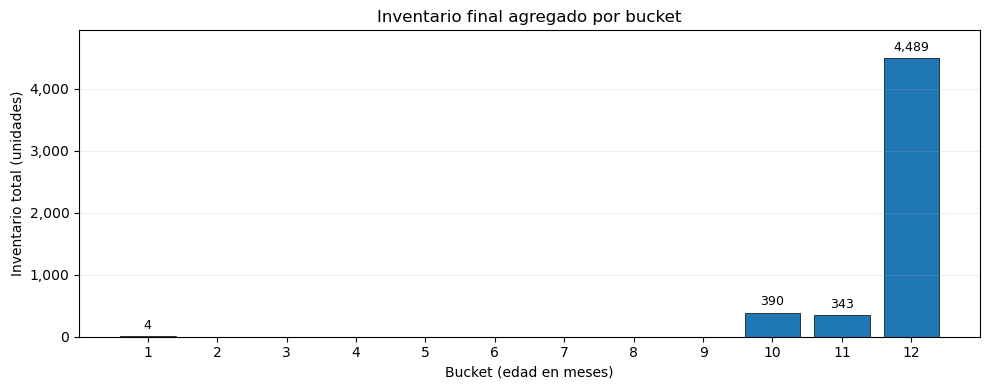

In [36]:
#Celda 38 Gráfico inventario final


#localizar columnas de forma robusta
col_item = next(c for c in df_inv.columns if str(c).strip().lower().startswith("item"))
col_age  = next(c for c in df_inv.columns if "edad" in str(c).strip().lower())
col_inv  = next(c for c in df_inv.columns if ("inventario" in str(c).lower() and "final" in str(c).lower()))

## agregar inventario final por bucket (edad)
agg = (df_inv.groupby(col_age, as_index=False)[col_inv].sum().rename(columns={col_age: "Bucket", col_inv: "Inventario_total"}))

# asegurar buckets 1..12 presentes
A = list(range(1, 13))
agg = (pd.DataFrame({"Bucket": A}).merge(agg, on="Bucket", how="left").fillna({"Inventario_total": 0}))

display(agg.sort_values("Bucket"))

#gráfico
fig, ax = plt.subplots(figsize=(10, 4))

bars = ax.bar(agg["Bucket"],agg["Inventario_total"],color="tab:blue",edgecolor="black",linewidth=0.5)

# formateo de ejes: miles con coma
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

ax.set_xlabel("Bucket (edad en meses)")
ax.set_ylabel("Inventario total (unidades)")
ax.set_title("Inventario final agregado por bucket")
ax.set_xticks(A)
ax.grid(axis="y", alpha=0.2)

# margen superior para que quepan los números
ymax = agg["Inventario_total"].max()
ax.set_ylim(0, (ymax * 1.10) if ymax > 0 else 1)

# etiquetas de valor centradas sobre cada barra
for bar in bars:
    h = bar.get_height()
    if h > 0:
        ax.annotate(
            f"{h:,.0f}",
            xy=(bar.get_x() + bar.get_width() / 2, h),xytext=(0, 3), textcoords="offset points",ha="center", va="bottom", fontsize=9, color="black")

fig.tight_layout()
plt.show()


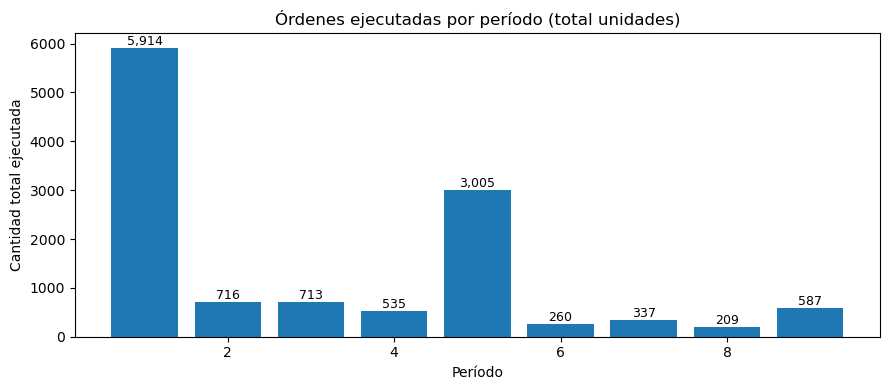

In [37]:
##Celda 39 Gráfico de órdenes ejecutadas por período 

##Armar df_ejec si plan_ejecutado existe
if 'plan_ejecutado' in globals() and len(plan_ejecutado) > 0:
    df_ejec = pd.DataFrame(plan_ejecutado, columns=["Periodo","Item","Modo","Cantidad"])
    df_ejec["Periodo"]  = pd.to_numeric(df_ejec["Periodo"], errors="coerce")
    df_ejec["Cantidad"] = pd.to_numeric(df_ejec["Cantidad"], errors="coerce").fillna(0.0)
    df_ejec = df_ejec[df_ejec["Cantidad"] > 0]
else:
    print("No hay datos en plan_ejecutado. Corre primero el bucle del horizonte rodante.")
    df_ejec = pd.DataFrame(columns=["Periodo","Item","Modo","Cantidad"])

##  Barras por período
if not df_ejec.empty:
    suma_por_periodo = df_ejec.groupby("Periodo", as_index=True)["Cantidad"].sum().sort_index()
    plt.figure(figsize=(9,4))
    bars = plt.bar(suma_por_periodo.index.astype(int), suma_por_periodo.values)
    plt.xlabel("Período")
    plt.ylabel("Cantidad total ejecutada")
    plt.title("Órdenes ejecutadas por período (total unidades)")
    for b in bars:
        h = b.get_height()
        if h>0:
            plt.text(b.get_x()+b.get_width()/2, h, f"{int(round(h)):,}",
                     ha="center", va="bottom", fontsize=9)
    plt.tight_layout()
    plt.show()


=== Demanda total por período (todas los ítems) ===


,Periodo,Demanda
0,1,4597.0
1,2,499.0
2,3,8697.0
3,4,1107.0
4,5,831.0
5,6,783.0
6,7,3354.0
7,8,482.0
8,9,489.0
9,10,294.0



=== Demanda por ítem y período (preview) ===


,Item,Periodo,Demanda
0,SNPA157C,1,1.0
1,SNPA157C,2,0.0
2,SNPA157C,3,0.0
3,SNPA157C,4,0.0
4,SNPA157C,5,0.0
5,SNPA157C,6,0.0
6,SNPA157C,7,0.0
7,SNPA157C,8,0.0
8,SNPA157C,9,0.0
9,SNPA157C,10,0.0


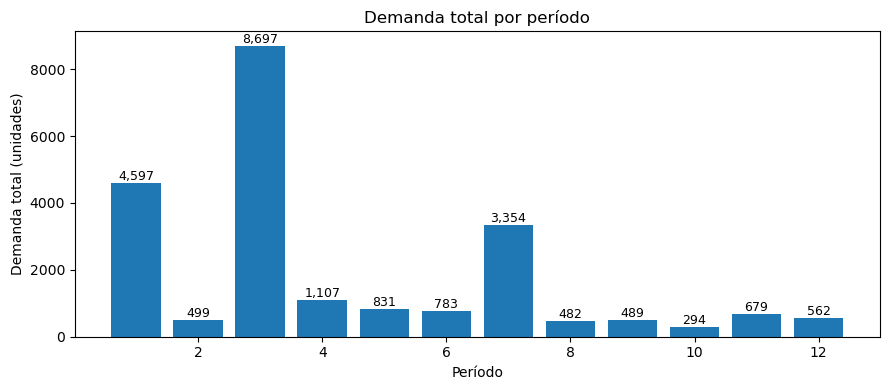

In [38]:
## Celda 40 – Demanda por período

import pandas as pd
import matplotlib.pyplot as plt

# 1) Pasar D_it a un DataFrame detallado (item, periodo)
rows = []
for i in I:
    for t in T:
        rows.append((i, t, D_it[i][t]))

df_dem = pd.DataFrame(rows, columns=["Item", "Periodo", "Demanda"])

print("=== Demanda total por período (todas los ítems) ===")
df_dem_tot = (df_dem
              .groupby("Periodo", as_index=False)["Demanda"]
              .sum()
              .sort_values("Periodo"))
display(df_dem_tot)

print("\n=== Demanda por ítem y período (preview) ===")
display(df_dem.head(20))

# 2) Gráfico de barras demanda total por período
plt.figure(figsize=(9,4))
bars = plt.bar(df_dem_tot["Periodo"], df_dem_tot["Demanda"])
plt.xlabel("Período")
plt.ylabel("Demanda total (unidades)")
plt.title("Demanda total por período")

for b in bars:
    h = b.get_height()
    if h > 0:
        plt.text(b.get_x()+b.get_width()/2, h, f"{int(round(h)):,}",
                 ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
